# _Notebook Jupyter_ 8_prediçãoRisco

# Predição do Risco dada uma Importação

O objetivo agora é dada uma importação contendo **kit de transmissão de motocicletas** fazer a sua classificação e em seguida apresentar uma análise de risco visual baseada na estatística existente de outras importações.<br>
É importante salientar que esta análise não substitui a acurada análise a ser realizada por um Auditor Fiscal, tendo em vista que o resultado será uma lista de parâmetros objetivos que indicarão graus de observação para o gerenciamento de risco.
Desse modo, a entrada será o registro de importação contendo todos os campos. A função determinará a classificação e com base nos valores declarados de outras importações da mesma classificação, fará a comparação analítica com o valor da importação em análise.

## Importando bibliotecas

In [1]:
import pandas as pd, time
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# importa funções criadas no TCC e que precisam ser reutilizadas
from funcoesTCC import *
# Funções: criaModelo, limpaDescricao, achaPalavraChave, pegaChave, acrescentaMarca, retentorAux, classificaAplicacao
# Variávis: stopwords, palavrasChave, Marcas, cvt, tfi, clfsvc
# Datasets: dfaplicacoes (Aplicações)

In [3]:
# Data e hora da execução do script
initot=time.time()
print(f'Código executado em {time.strftime("%d/%m/%Y às %H:%M", time.localtime(time.time()))}')

Código executado em 20/01/2022 às 17:39


## Carregamento do _dataset_

In [4]:
# Importa base de dados com os modelos já determinados para um dataframe
df = pd.read_excel(r'./bases/dataframe_modelos_classificado.xlsx')

##### Define dataset para gerar os relatórios

In [5]:
dfimp=df.sample(50)
dfimp.sample()

,PAIS DE ORIGEM,DESCRICAO DO PRODUTO,VALOR UN.PROD.DOLAR,DESCRICAO,Modelo,APLICACAO,RETENTOR
12863,"CHINA, REPUBLICA POP","20181/i45 - KIT DE TRANSMISSÃO EM AÇO 1045, MA...",3.56,ybr125,125 yamaha ybr ybr125,YAMAHA FACTOR YBR 125 YBR125,False


### Teste do classificador

O classificador treinado e as funções de classificação foram importadas no módulo funcoesTCC

In [6]:
descricao = df.iloc[117]['DESCRICAO DO PRODUTO'] 
# verifica a descrição do produto
descricao

'KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS XTZ 125, COMPOSTO DE CORRENTE 428 X M138 + COROA 41555 48Z + PINHAO 26571 14Z (CERTIFICADO NR. BR31512030) - ITEM: 71817'

In [7]:
classificaAplicacao(descricao)

'YAMAHA XTZ 125'

## Importando a Tabela ABIMOTO

In [8]:
dfABIMOTO = pd.read_excel(r'./bases/dfABIMOTOv13.xlsx')

In [9]:
dfABIMOTO.sample()

,PARTES E PEÇAS,VMLE,RETENTOR,APLICACAO
7,KIT TRANSMISSÃO 1045 TITAN 2000/04 14D+428HX11...,4.3,False,HONDA CG TIT TITAN 125 150 160


#### Função de busca do valor da Aplicação na Tabela ABIMOTO

In [10]:
def achaValorABIMOTO(aplicacao, retentor):
    # aplicação = string (aplicação da importação atual)
    # retentor = boolean (identificador da presença de retentor na importação atual)
    # retorna o valor na tabela ABIMOTO ou 0 se não existir a aplicação
    dfABtemp=dfABIMOTO[dfABIMOTO['APLICACAO']==aplicacao]
    dfABtemp=dfABtemp[dfABtemp['RETENTOR']==retentor]
    if dfABtemp.shape[0]==0:
        return 0
    return min(dfABtemp['VMLE'])

## Função de determinação do risco

Uma observação muito importante a ser feita, foi quanto aos valores _outliers_, isto é, valores atípicos, posto que alguns itens eram discrepantes, fosse por ser uma sub ou sobrevaloração do item ou fosse porque alguns importadores insistem em, erroneamente, declarar caixas com vários kits em vez de unidades.<br>
A identificação de _outliers_, distantes dos demais pontos da série, pode ser feita utilizando o intervalo interquartílico (IQR). Entende-se como _outlier_, valores menores que Q1-1,5*IQR ou valores maiores que Q3+1,5*IQR.<br>
Estes valores também são representados no boxplot, mas como pontos acima ou abaixo da linha conectada à caixa. Vejamos um desenho de um boxplot com todos estes conceitos:

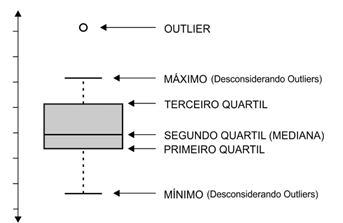

Apesar da bibliografia indicar o uso de uma vez e meia o intervalo entre o primeiro e o terceiro quartil para definir os _outliers_, optou-se nesse trabalho, por uma questão de segurança, em utilizar o valor de três vezes.

#### Função de plotagem da Previsão de Risco

In [11]:
def plotrisco(P, valor,valorABIMOTO=0):
    # P (lista) = percentis da base histórica da aplicação importada
    # valor (float) = valor declarado na importação analisada
    # valorABIMOTO (float) = valor de referência na tabela ABIMOTO (0, se não exisitr)
    # cria o plot
    fig, ax = plt.subplots(figsize=(10, 1.25))
    
    # define os dados sequenciais, posição e cores dos percentis
    ax.broken_barh([(0,P[0]),(P[0],P[1]), (P[1],P[11]), (P[11],P[3]), (P[3],P[4]), (P[4],P[5]),
                             (P[5],P[6]), (P[6],P[7]), (P[7],P[8]), (P[8],P[9]), (P[9],P[10])], 
                    [10, 9], 
                   facecolors=('#c10000', 'r', 'r','#fdff01', '#00fe32', '#02ff00', 
                               '#02ff00','#02ff00', '#00fe32','#00fe32', '#006dff'))
    
    # define limites dos eixos x e y
    ax.set_ylim(10,15)
    ax.set_xlim(P[0], P[10])
    
    # define os marcadores dos eixos
    ax.set_yticks([])
    ax.set_xticks([P[11],P[5],P[9]])
    ax.set_axisbelow(True)
    
    # define os textos
    # identificação dos percentis
    ax.text(P[1], 15.5, "P10%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(P[1], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    ax.text(P[11], 15.5, "P25%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(P[11], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    ax.text(P[5], 15.5, "P50%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(P[5], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    ax.text(P[12], 15.5, "P75%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(P[12], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    ax.text(P[9], 15.5, "P90%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(P[9], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    ax.text(P[10], 15.5, "P100%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(P[10], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    # o valor (P[10]-P[0])/40 relativiza a escala na hora de mover algo no gráfico.
    undrelativa = (P[10]-P[0])/40
    # identificação de mínimo, mediana e máximo
    ax.text(P[0]-1*undrelativa, 12.5, f"Min({P[0]})", fontsize=12, verticalalignment='center', horizontalalignment='center',rotation='vertical')
    ax.text((P[5]), 8, "Mediana", fontsize=12, verticalalignment='center', horizontalalignment='center')
    ax.text(P[10]+1*undrelativa, 12.5, f"Máx({P[10]})", fontsize=12, verticalalignment='center', horizontalalignment='center',rotation='vertical')
    
    # define alertas
    alerta=''
    # alerta quando valor fora dos limites máximo e mínimo
    if valor<P[0] or valor>P[10]:
        alerta+=f"ATENÇÃO: Valor declarado de USD{valor:.2f} fora dos limites do modelo (outlier)."
        alerta+='\n'
    if valorABIMOTO>valor:
        alerta+=f"ATENÇÃO: Valor declarado de USD{valor:.2f} menor que referência mínima ABIMOTO: USD{valorABIMOTO:.2f}."
    ax.text((P[10]+P[0])/2, 6, alerta, fontsize=13, color='r', verticalalignment='center', horizontalalignment='center')
    
    # define o título
    fig.suptitle('Previsão de Risco', fontsize=13, y=1.5, horizontalalignment='center')
    
    # define cores do ponteiro indicador
    cores=['#a20000','#ff6900', '#007d00', '#00007d'] # vermelho, amarelo, verde, azul
    # condições para determinar a cor do ponteiro
    if   valor>=P[9]: cor=cores[3]
    elif valor>=P[3]: cor=cores[2]
    elif valor>=P[11]: cor=cores[1]
    else:             cor=cores[0]

    # plota o ponteiro e o valor
    ax.scatter(x=valor, y=10.9, marker='v', c=cor, s=400)
    ax.text(valor, 12.2, valor, color='black', fontsize=14, verticalalignment='center', horizontalalignment='center')
    ax.vlines(x=P[5], ymin=10, ymax=15)
    
    # se existir valor na tabela ABIMOTO coloca o indicador e valor
    if valorABIMOTO>0:
        ax.scatter(x=valorABIMOTO, y=10.7, marker='v', c='black', s=200)
        if valorABIMOTO>valor:
            ax.text(valorABIMOTO+1*undrelativa, 10.6, f'{valorABIMOTO:.2f}(ABIMOTO)', color='black', fontsize=12, verticalalignment='center', horizontalalignment='left')
        else:
            ax.text(valorABIMOTO-1*undrelativa, 10.6, f'(ABIMOTO){valorABIMOTO:.2f}', color='black', fontsize=12, verticalalignment='center', horizontalalignment='right')

    # mostra o gráfico
    plt.show()

#### Função que calcula o risco de valoração

In [12]:
def riscoValor(dfimp):
    # dfimp será uma série ou dataframe pandas contendo as importações a analisar
    # caso seja um dataframe e tenha mais de uma linha, será iterada sobre todas as linhas.
    if type(dfimp)==type(pd.Series([])):    tipo='s' # se for tipo series ==> s
    if type(dfimp)==type(pd.DataFrame([])): tipo='d' # se for tipo dataframe ==> d
    if not(tipo=='s' or tipo=='d'): # se o tipo não for séries ou dataframe ==> erro
        raise TypeError('É preciso entrar com um dataframe ou uma Series do pandas.')
    if tipo=='d': # se for do tipo dataframe
        for i, linha in dfimp.iterrows(): # executa a função novamente para cada linha (series)
            riscoValor(linha) # reexecuta para cada linha se fornecido um dataframe (recursividade)
    if tipo=='s':
        print('\x1b[1;31m'+'RELATÓRIO DE RISCO'+'\x1b[0m')
        print('\x1b[1;31m'+'\nDados da Declaração de Importação'+'\x1b[0m')
        descricao=dfimp['DESCRICAO DO PRODUTO']
        origem=dfimp['PAIS DE ORIGEM']
        retentor=retentorAux(dfimp['DESCRICAO DO PRODUTO'])
        retentortexto="com retentor" if retentor else "sem retentor"
        aplicacao=classificaAplicacao(descricao)
        valor=round(dfimp['VALOR UN.PROD.DOLAR'],2)
        valorABIMOTO=achaValorABIMOTO(aplicacao, retentor)
        print(f'Descrição: {descricao}\n'+
              f'Origem:    {origem}\n'+
              f'Retentor:  {retentortexto}\n'+
              f'Aplicação: {aplicacao}\n'+
              f'Valor DI:  USD {valor:.2f}')
        if valorABIMOTO>0: print(f'Tabela de Referência ABIMOTO\nValor:     USD {valorABIMOTO:.2f}\n')
        # filtra o df somente para os registros da aplicação classificda
        dfrisco=df[df['APLICACAO']==aplicacao] # filtra para a aplicação
        dfrisco=dfrisco[dfrisco['RETENTOR']==retentor] # filtra para a existência de retentor
        # remove os valores discrepantes dos dados
        # filtra somente valores de Q25-discrepancia*(Q75-Q25) a Q75+*discrepancia*(Q75-Q25)
        discrepancia=3 # valor padrão=1.5 
        P25=np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],25)
        P75=np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],75)
        min=P25-discrepancia*(P75-P25)
        max=P75+discrepancia*(P75-P25)
        filtro=[min<=dfrisco['VALOR UN.PROD.DOLAR']] and [dfrisco['VALOR UN.PROD.DOLAR']<=max]
        dfrisco=dfrisco[filtro[0]]
        # recálculo dos quartis 25 e 75 para df sem outliers
        P25=np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],25)
        P75=np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],75)
        # geração da lista com os quartis
        P=[round(np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],x),2) for x in range(0,110,10)]+[round(P25,2),round(P75,2)]
        estatisticas=dfrisco.describe()['VALOR UN.PROD.DOLAR']
        estatisticas.rename(index={'count':'qtd de registros:','mean':'média simples:','std':'desvio padrão:','min':'valor mínimo:','25%':'percentil 25%:','50%':'percentil 50%:','75%':'percentil 75%:','max':'valor máximo:'}, inplace=True)
        print('\x1b[1;31m'+f'Estatísticas:\n'+'\x1b[0m'+f'{estatisticas.to_string()}\n')
        # fazer um plot indicando a posição do valor em uma barra variando em vermelho-amarelo-verde-azul
        quartil={}
        for x in range(0,10): quartil[10+x*10] = P[x]
        quartil[25]=P25
        quartil[75]=P75
        perc=[f'{chave}={quartil[chave]:.2f}' for chave in sorted(quartil.keys())]
        print('\x1b[1;31m'+f'Percentis:\n'+'\x1b[0m'+f'  {str(perc[:6])[1:-1]}\n  {str(perc[6:])[1:-1]}')
        print('\x1b[1;31m'+f'\nHistograma:'+'\x1b[0m')
        plt.figure(figsize=(10,5),frameon=False)
        plt.hist(dfrisco['VALOR UN.PROD.DOLAR'],10,rwidth=0.9,range=(P[0],P[10]))
        plt.show()
        print('\x1b[1;31m'+f'Previsão de Risco:'+'\x1b[0m')
        plotrisco(P,valor,valorABIMOTO)
        print('\n\n')

RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 22317 - 91131 - KIT DE TRANSMISSÃO PARA MOTOCICLETA - MODELO C 100 BIZ (13-15) - CONTENDO COROA 34Z - PINHAO 14Z - C/CORRENTE 428H X 108L - TITANIUM (1045)
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ C100 125 C125
Valor DI:  USD 4.09
Tabela de Referência ABIMOTO
Valor:     USD 3.90

Estatísticas:
qtd de registros:    1434.000000
média simples:          3.742230
desvio padrão:          0.618322
valor mínimo:           1.202000
percentil 25%:          3.290000
percentil 50%:          3.713600
percentil 75%:          4.090000
valor máximo:           6.511000

Percentis:
  '10=1.20', '20=3.06', '25=3.29', '30=3.23', '40=3.36', '50=3.55'
  '60=3.71', '70=3.79', '75=4.09', '80=3.94', '90=4.13', '100=4.48'

Histograma:


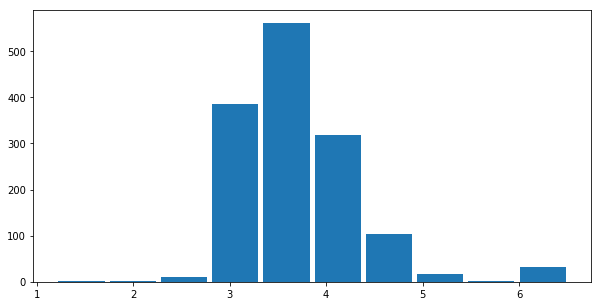

Previsão de Risco:


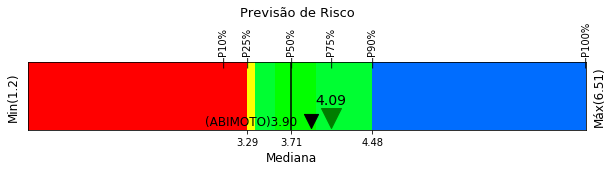

In [13]:
riscoValor(df.iloc[2103])

RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: - KIT TRANSMISSAO TITANIUM PARA MOTOCICLETAS MODELO XTZ 150 CROSSER (14-18) 41Z X 14Z WITH CHAIN 428H X 122L, COMPOSTO POR CORRENTE, COROA E PINHÃO. CORRENTE FABRICADA EM AÇO, PERFIL: 428 REFORÇADA, 126 ELOS; COROA FABRICADA EM AÇO TITANIUM, DE 41 DE
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA XTZ CROSSER 150
Valor DI:  USD 5.83
Estatísticas:
qtd de registros:    376.000000
média simples:         4.945683
desvio padrão:         1.470404
valor mínimo:          1.371000
percentil 25%:         3.740000
percentil 50%:         4.905000
percentil 75%:         5.654700
valor máximo:          9.150000

Percentis:
  '10=1.37', '20=3.52', '25=3.74', '30=3.67', '40=3.85', '50=4.00'
  '60=4.90', '70=5.15', '75=5.65', '80=5.52', '90=5.73', '100=7.08'

Histograma:


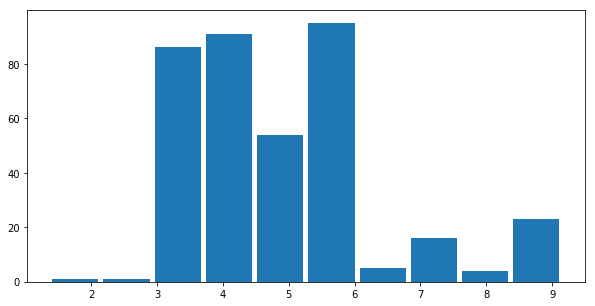

Previsão de Risco:


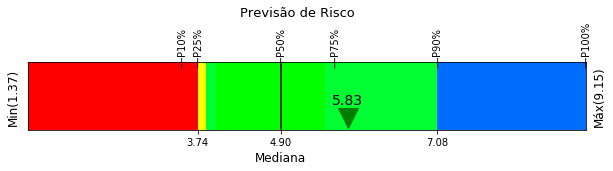




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: TM10130R - KIT DE TRANSMISSÃO COMPOSTO DE COROA, CORRENTE E PINHÃO PARA MOTOCICLETA - UTILIZADAS NAS MOTOCICLETAS - NXR 150 Bross - 50T / 17T + 428HO X 130L - SUA FUNÇÃO É TRANSMITIR O MOVIMENTO DA CAIXA DE CÂMBIO ATÉ A RODA TRASEIRA, TAMBÉM É RESPON
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 160 BROZ
Valor DI:  USD 6.31
Estatísticas:
qtd de registros:    1816.000000
média simples:          5.664408
desvio padrão:          1.760071
valor mínimo:           1.642000
percentil 25%:          4.387500
percentil 50%:          5.349000
percentil 75%:          5.845760
valor máximo:          11.527981

Percentis:
  '10=1.64', '20=4.04', '25=4.39', '30=4.27', '40=4.51', '50=4.79'
  '60=5.35', '70=5.57', '75=5.85', '80=5.70', '90=6.61', '100=8.69'

Histograma:


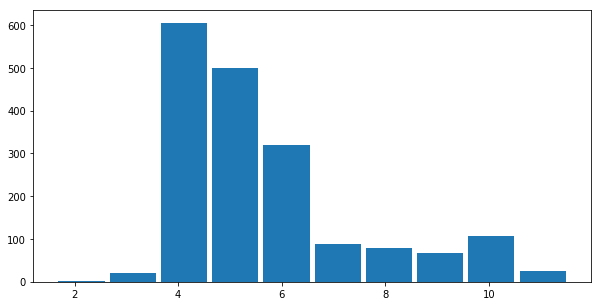

Previsão de Risco:


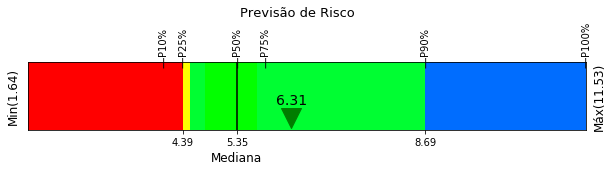




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSÃO DE AÇO - COMPOSTO DE: COROA COM 34 DENTES E PINHÃO COM 14 DENTES, CORRENTE DE PERFIL 428H E 106L ELOS, NOME: COMERCIAL: KIT TRACAO. MARCA TOP NOTCH. PEÇAS PARA UTILIZAÇÃO EM MOTOCICLETAS MODELO: C-125 BIZ (SEM RETENTOR).
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ C100 125 C125
Valor DI:  USD 3.05
Tabela de Referência ABIMOTO
Valor:     USD 3.90

Estatísticas:
qtd de registros:    1434.000000
média simples:          3.742230
desvio padrão:          0.618322
valor mínimo:           1.202000
percentil 25%:          3.290000
percentil 50%:          3.713600
percentil 75%:          4.090000
valor máximo:           6.511000

Percentis:
  '10=1.20', '20=3.06', '25=3.29', '30=3.23', '40=3.36', '50=3.55'
  '60=3.71', '70=3.79', '75=4.09', '80=3.94', '90=4.13', '100=4.48'

Histograma:


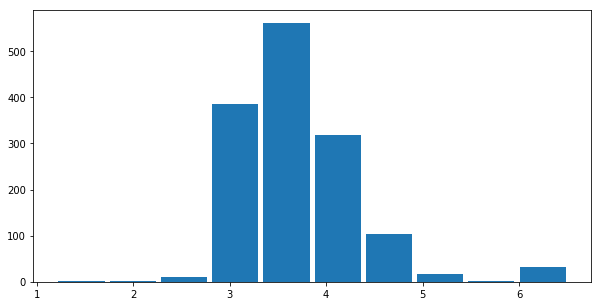

Previsão de Risco:


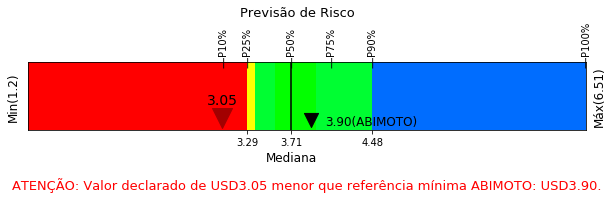




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 10530021 IN KIT TRANSMISSÃO P/MOTOCICLETAS(COROA, CORRENTE, PINHAO) WEB-100 14D/36D 428HX108L MARCA: SCUD
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: SUNDOWN WEB
Valor DI:  USD 3.57
Estatísticas:
qtd de registros:    257.000000
média simples:         3.857832
desvio padrão:         0.791772
valor mínimo:          2.260000
percentil 25%:         3.283000
percentil 50%:         3.573000
percentil 75%:         4.530000
valor máximo:          5.638000

Percentis:
  '10=2.26', '20=3.00', '25=3.28', '30=3.21', '40=3.35', '50=3.47'
  '60=3.57', '70=3.79', '75=4.53', '80=3.91', '90=4.68', '100=5.29'

Histograma:


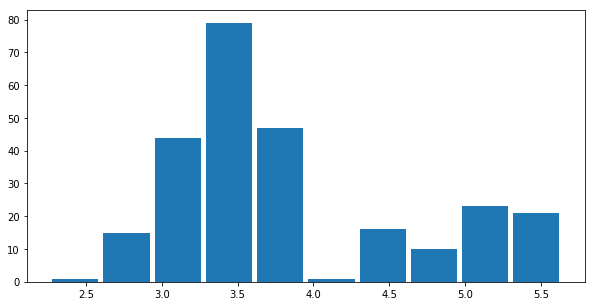

Previsão de Risco:


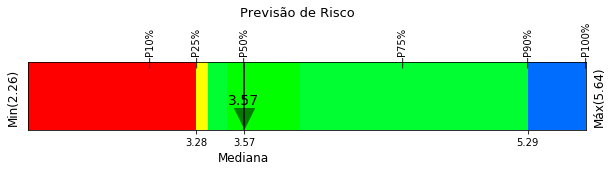




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSÃO EM AÇO 1045, PARA USO EM MOTOCICLETA, COMPOSTO POR CORRENTE, COROA E PINHÃO, (48T/16T + 428H x128L), COMPATÍVEL COM MOTOCICLETA(S) MODELO(S): NXR 160 BROS / XRE 190. MARCA: CEVER PREMIUM. CODIGO: 0022334.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 160 BROZ
Valor DI:  USD 3.88
Estatísticas:
qtd de registros:    1816.000000
média simples:          5.664408
desvio padrão:          1.760071
valor mínimo:           1.642000
percentil 25%:          4.387500
percentil 50%:          5.349000
percentil 75%:          5.845760
valor máximo:          11.527981

Percentis:
  '10=1.64', '20=4.04', '25=4.39', '30=4.27', '40=4.51', '50=4.79'
  '60=5.35', '70=5.57', '75=5.85', '80=5.70', '90=6.61', '100=8.69'

Histograma:


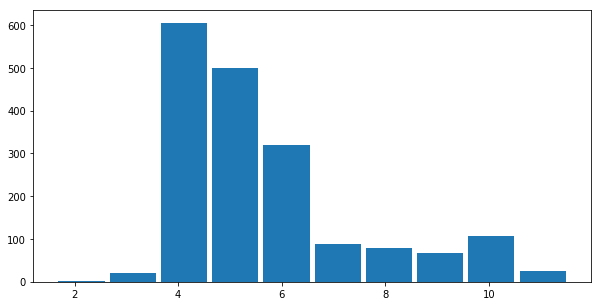

Previsão de Risco:


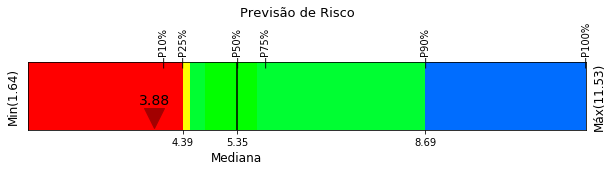




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS CG 60 TITAN (16-19)/ CG 160 FAN (16-19)/ CG 160 START (16-19)/ CG 160 CARGO (16-19), COMPOSTO DE CORRENTE 428 X SM118 + COROA S40307 44Z + PINHAO 25111 15Z (CERTIFICADO NR. BR315120
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG FAN
Valor DI:  USD 4.10
Estatísticas:
qtd de registros:    2378.000000
média simples:          4.188226
desvio padrão:          0.455430
valor mínimo:           1.554000
percentil 25%:          3.920000
percentil 50%:          4.090000
percentil 75%:          4.528700
valor máximo:           6.870000

Percentis:
  '10=1.55', '20=3.66', '25=3.92', '30=3.87', '40=3.95', '50=4.01'
  '60=4.09', '70=4.18', '75=4.53', '80=4.50', '90=4.58', '100=4.70'

Histograma:


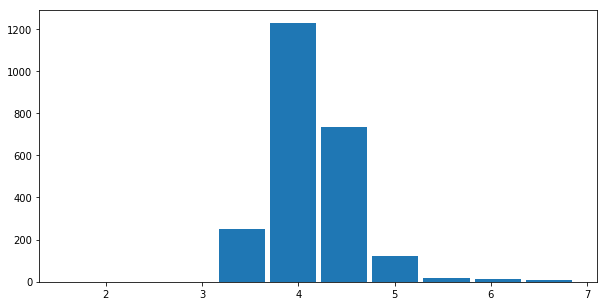

Previsão de Risco:


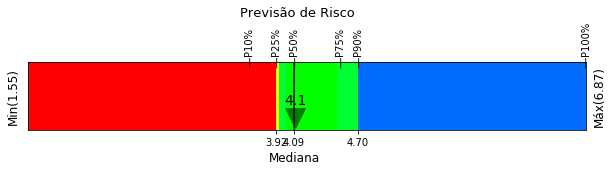




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 10530042 IN KIT TRANSMISSAO P/MOTOCICLETAS(COROA, CORRENTE, PINHAO) MODELO: CRYPTON 115 2010/13 15D/41D 420HX108L MARCA: SCUD
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA CRYPTON
Valor DI:  USD 3.34
Estatísticas:
qtd de registros:    247.000000
média simples:         4.076849
desvio padrão:         0.936688
valor mínimo:          2.840000
percentil 25%:         3.344000
percentil 50%:         3.571000
percentil 75%:         5.191200
valor máximo:          5.777000

Percentis:
  '10=2.84', '20=3.14', '25=3.34', '30=3.23', '40=3.36', '50=3.48'
  '60=3.57', '70=3.75', '75=5.19', '80=5.19', '90=5.24', '100=5.36'

Histograma:


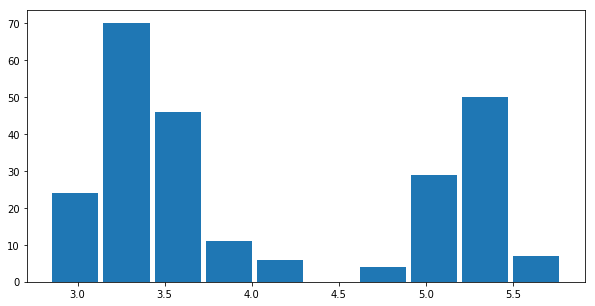

Previsão de Risco:


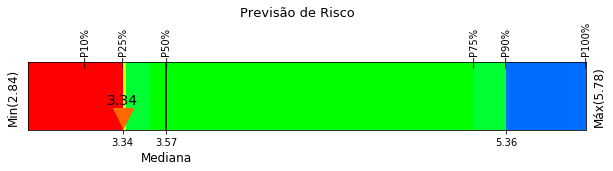




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSÃO DE AÇO - COMPOSTO DE: COROA COM 36 DENTES E PINHÃO COM 14 DENTES, CORRENTE DE PERFIL 428H E 108L ELOS, NOME: COMERCIAL: KIT TRACAO. MARCA TOP NOTCH. PEÇAS PARA UTILIZAÇÃO EM MOTOCICLETAS MODELO: WEB 100 (SEM RETENTOR).
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: SUNDOWN WEB
Valor DI:  USD 3.16
Estatísticas:
qtd de registros:    257.000000
média simples:         3.857832
desvio padrão:         0.791772
valor mínimo:          2.260000
percentil 25%:         3.283000
percentil 50%:         3.573000
percentil 75%:         4.530000
valor máximo:          5.638000

Percentis:
  '10=2.26', '20=3.00', '25=3.28', '30=3.21', '40=3.35', '50=3.47'
  '60=3.57', '70=3.79', '75=4.53', '80=3.91', '90=4.68', '100=5.29'

Histograma:


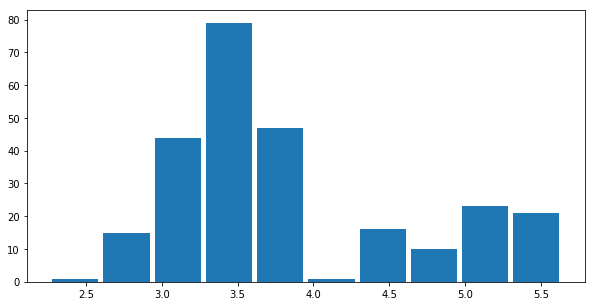

Previsão de Risco:


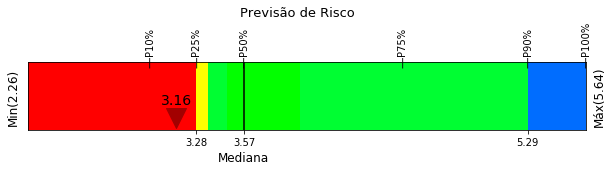




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS YBR 125 (03-08)/ YBR 125 FACTOR (03-16), COMPOSTO DE CORRENTE 428 X SM118 + COROA S41550 45Z + PINHAO 26571 14Z (CERTIFICADO NR. BR31512027) - ITEM: 71815
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 3.98
Tabela de Referência ABIMOTO
Valor:     USD 4.20

Estatísticas:
qtd de registros:    1092.000000
média simples:          4.278391
desvio padrão:          0.824252
valor mínimo:           1.436000
percentil 25%:          3.720000
percentil 50%:          4.060000
percentil 75%:          4.702000
valor máximo:           8.150000

Percentis:
  '10=1.44', '20=3.49', '25=3.72', '30=3.65', '40=3.79', '50=3.98'
  '60=4.06', '70=4.14', '75=4.70', '80=4.53', '90=4.85', '100=5.44'

Histograma:


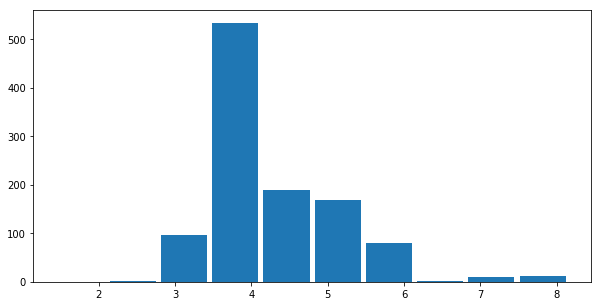

Previsão de Risco:


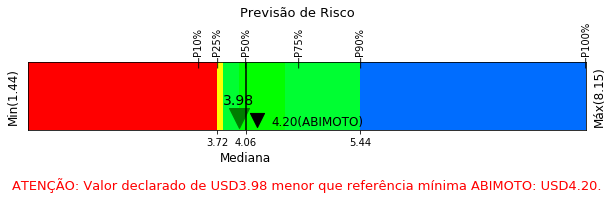




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT TRANSMISSÃO PARA MOTOCICLETAS,COMPOSTO DE CORRENTE,PINHAO E COROA, PARA MODELOS DIVERSOS DE MOTOCICLETAS, Kit Coroa 40T + Pinhão 13T + 520HO X 110L - COMMODITY/MODELO: CBX 250 TWISTER 2016-2018, CODIGO S1045, MARCA: IRON (MOTOPARTS), SHIPPING MAR
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA TWISTER CBX 250
Valor DI:  USD 11.92
Tabela de Referência ABIMOTO
Valor:     USD 6.25

Estatísticas:
qtd de registros:    540.000000
média simples:         7.933863
desvio padrão:         2.866362
valor mínimo:          2.704810
percentil 25%:         5.886239
percentil 50%:         7.402751
percentil 75%:         8.670000
valor máximo:         17.482800

Percentis:
  '10=2.70', '20=5.18', '25=5.89', '30=5.70', '40=6.00', '50=6.86'
  '60=7.40', '70=7.92', '75=8.67', '80=8.47', '90=8.86', '100=12.70'

Histograma:


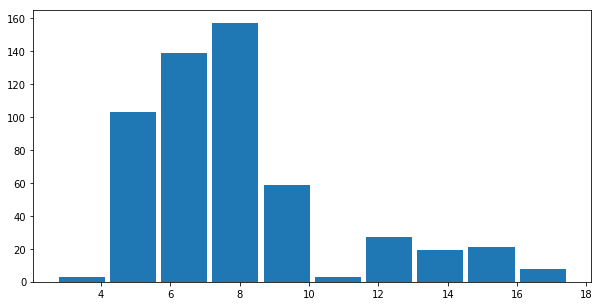

Previsão de Risco:


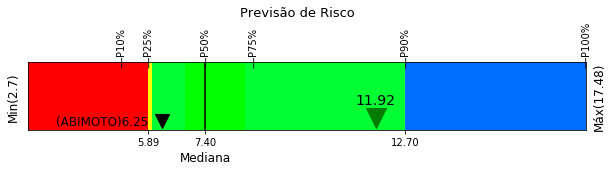




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: ENGRENAGENS PARA TRANSMISSÃO DE MOTOCICLETAS E CICLOMOTORES, SENDO, KIT DE TRANSMISSÃO TOP (1045) PARA NRX 150 BROS ( 06-15 ), COMPOSTO DE CORRENTE 428HO X 128L, COROA 19Z, PINHÃO 17Z COM ORING - ITEM 91089.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 160 BROZ
Valor DI:  USD 10.03
Estatísticas:
qtd de registros:    1816.000000
média simples:          5.664408
desvio padrão:          1.760071
valor mínimo:           1.642000
percentil 25%:          4.387500
percentil 50%:          5.349000
percentil 75%:          5.845760
valor máximo:          11.527981

Percentis:
  '10=1.64', '20=4.04', '25=4.39', '30=4.27', '40=4.51', '50=4.79'
  '60=5.35', '70=5.57', '75=5.85', '80=5.70', '90=6.61', '100=8.69'

Histograma:


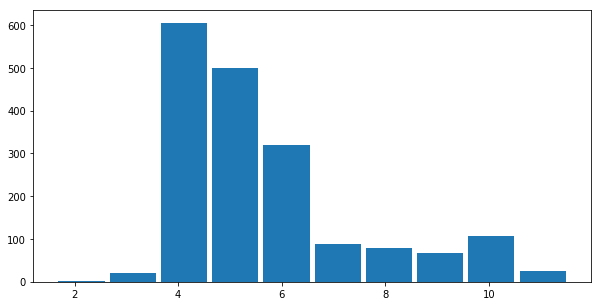

Previsão de Risco:


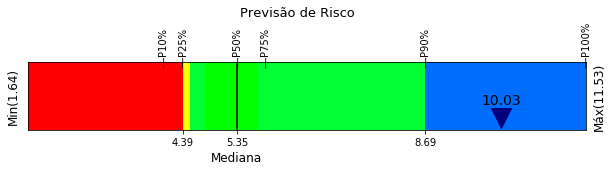




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT HARDT XTZ CROSSER 150 (2015/...) HO 41*14 - KIT DE TRANSMISSAO COM RETENTOR COMPOSTO DE COROA/PINHAO E CORRENTE PARA MODELO: XTZ CROSSER 150. COROA/PINHAO: 41*14, CORRENTE DA MOTOCICLETA 428HO E ELOS 122. REF. 55547C.
Origem:    CHINA, REPUBLICA POP
Retentor:  com retentor
Aplicação: YAMAHA XTZ CROSSER 150
Valor DI:  USD 3.36
Estatísticas:
qtd de registros:    25.000000
média simples:        6.862818
desvio padrão:        2.807560
valor mínimo:         3.260600
percentil 25%:        3.688653
percentil 50%:        7.550000
percentil 75%:        9.154000
valor máximo:        10.497308

Percentis:
  '10=3.26', '20=3.31', '25=3.69', '30=3.56', '40=3.79', '50=6.16'
  '60=7.55', '70=9.06', '75=9.15', '80=9.08', '90=9.61', '100=9.87'

Histograma:


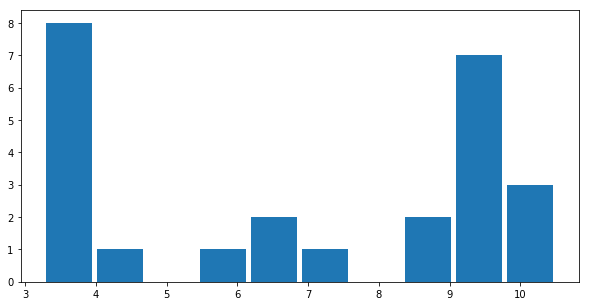

Previsão de Risco:


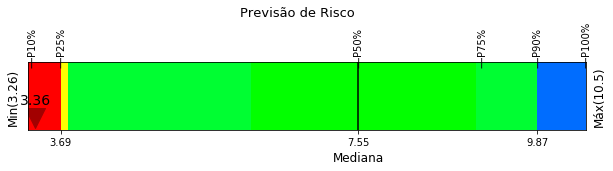




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 001-P21B-03100 001-P21B-03100 - KIT DE TRANSMISSÃO, CONTENDO CORRENTE, PINHAO E COROA - 1045 - 43D X 14D 428H X 118L STD - PARA USO EM MOTOCICLETAS MODELO YBR 125 00-02
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 3.49
Tabela de Referência ABIMOTO
Valor:     USD 4.20

Estatísticas:
qtd de registros:    1092.000000
média simples:          4.278391
desvio padrão:          0.824252
valor mínimo:           1.436000
percentil 25%:          3.720000
percentil 50%:          4.060000
percentil 75%:          4.702000
valor máximo:           8.150000

Percentis:
  '10=1.44', '20=3.49', '25=3.72', '30=3.65', '40=3.79', '50=3.98'
  '60=4.06', '70=4.14', '75=4.70', '80=4.53', '90=4.85', '100=5.44'

Histograma:


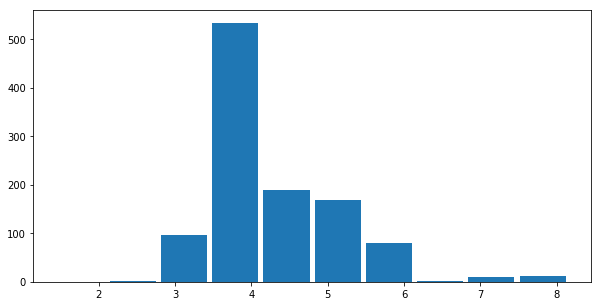

Previsão de Risco:


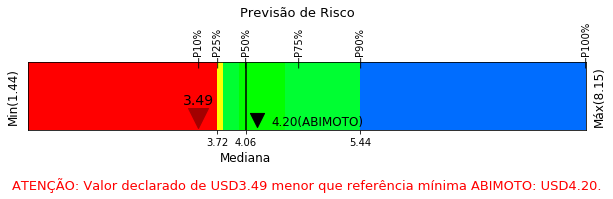




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KTD600 - KIT DE TRANSMISSÃO PARA MOTOCICLETAS, COMPOSTO DE CORRENTE, COROA E PINHÃO, COM RETENTOR, MODELO: 520HOx106L,45T/15T XT 600/TENERE , MARCA DUAS ALMAS
Origem:    CHINA, REPUBLICA POP
Retentor:  com retentor
Aplicação: YAMAHA XT 600
Valor DI:  USD 3.34
Estatísticas:
qtd de registros:     8.000000
média simples:        6.275291
desvio padrão:        4.327741
valor mínimo:         2.584000
percentil 25%:        2.649423
percentil 50%:        4.936157
percentil 75%:        8.383485
valor máximo:        13.314000

Percentis:
  '10=2.58', '20=2.62', '25=2.65', '30=2.65', '40=2.72', '50=3.20'
  '60=4.94', '70=6.66', '75=8.38', '80=7.13', '90=10.04', '100=12.35'

Histograma:


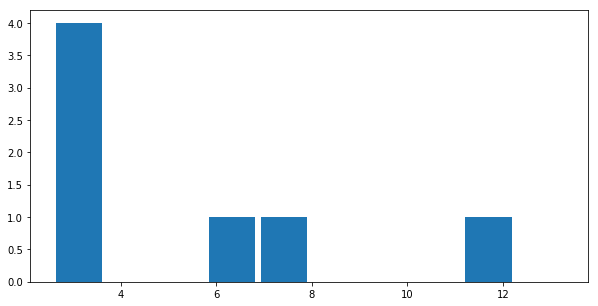

Previsão de Risco:


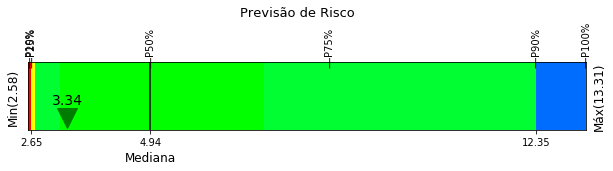




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO P MOTOCICLETA MOD.: FAZER 150; CONTENDO COROA 41Z ; PINHAO 14Z E CORRENTE DE TRANSMISSAO 428H X 126L MARCA: EVOL 358038 358038
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FAZER YS150 150
Valor DI:  USD 3.48
Estatísticas:
qtd de registros:    436.000000
média simples:         4.848136
desvio padrão:         1.226630
valor mínimo:          2.956300
percentil 25%:         3.825000
percentil 50%:         4.800000
percentil 75%:         5.654850
valor máximo:          9.790000

Percentis:
  '10=2.96', '20=3.55', '25=3.83', '30=3.75', '40=3.87', '50=4.28'
  '60=4.80', '70=5.23', '75=5.65', '80=5.65', '90=5.72', '100=5.83'

Histograma:


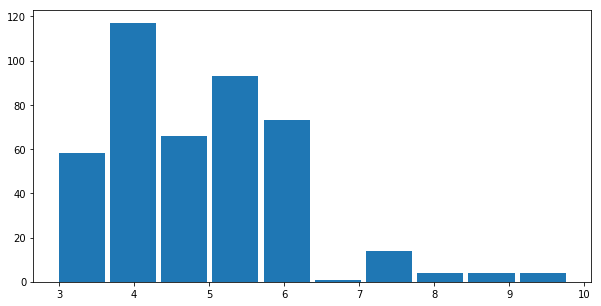

Previsão de Risco:


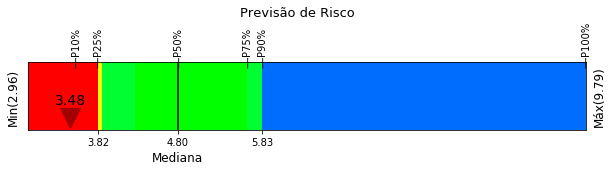




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT TRANSMISSÃO PARA MOTOCICLETAS,COMPOSTO DE CORRENTE,PINHAO E COROA,PARA MODELOS DIVERSOS DE MOTOCICLETAS (KIT CG 150 TITAN (04-15) / CG 160 CARGO (16-17) / CG 160 FAN (16-18) / CG 160 START (16-18) / CG 160 TITAN (16-18) 43Z X 16Z WITH CHAIN 428HO
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG FAN
Valor DI:  USD 9.45
Estatísticas:
qtd de registros:    2378.000000
média simples:          4.188226
desvio padrão:          0.455430
valor mínimo:           1.554000
percentil 25%:          3.920000
percentil 50%:          4.090000
percentil 75%:          4.528700
valor máximo:           6.870000

Percentis:
  '10=1.55', '20=3.66', '25=3.92', '30=3.87', '40=3.95', '50=4.01'
  '60=4.09', '70=4.18', '75=4.53', '80=4.50', '90=4.58', '100=4.70'

Histograma:


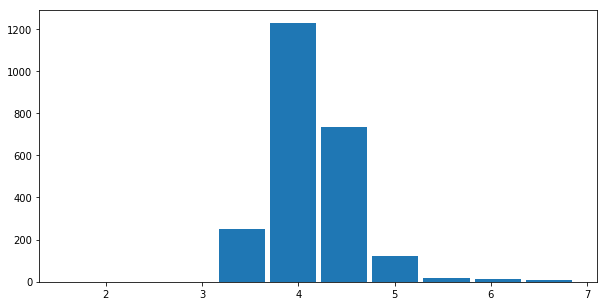

Previsão de Risco:


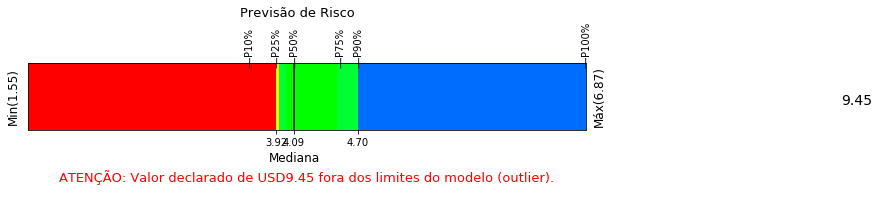




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 25003 - 001-P21B-00600 - KIT DE TRANSMISSÃO 1045 PARA MOTOCICLETA MODELO WEB 100 / PHOENIX 50 2014 - CONTENDO: COROA 36D - PINHAO 14D - C/CORRENTE 428H X 108L STD - MARCA P21.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: SUNDOWN WEB
Valor DI:  USD 3.54
Estatísticas:
qtd de registros:    257.000000
média simples:         3.857832
desvio padrão:         0.791772
valor mínimo:          2.260000
percentil 25%:         3.283000
percentil 50%:         3.573000
percentil 75%:         4.530000
valor máximo:          5.638000

Percentis:
  '10=2.26', '20=3.00', '25=3.28', '30=3.21', '40=3.35', '50=3.47'
  '60=3.57', '70=3.79', '75=4.53', '80=3.91', '90=4.68', '100=5.29'

Histograma:


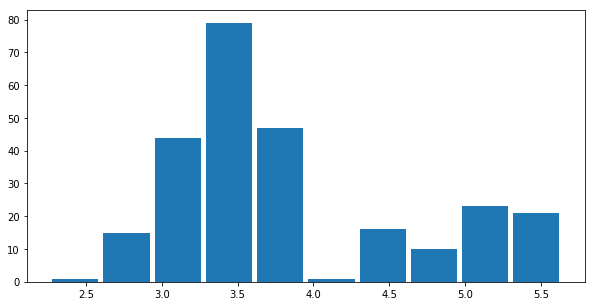

Previsão de Risco:


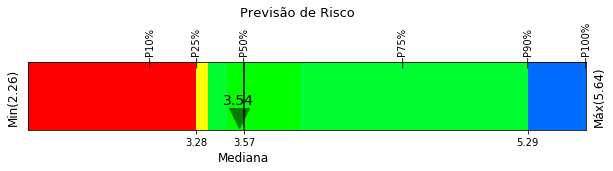




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 073754 - KIT TRANSMISSAO COMPOSTO DE CORRENTE, COROA E PINHAO, PARA MOTOCICLETA, SENDO: KIT RELACAO MAXX BROS160/XRE190 48D/16D 428X128 1045- MARCA MAXX PREMIUM
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA XRE 300
Valor DI:  USD 3.97
Tabela de Referência ABIMOTO
Valor:     USD 6.00

Estatísticas:
qtd de registros:    417.000000
média simples:         7.953195
desvio padrão:         3.009177
valor mínimo:          3.791250
percentil 25%:         5.634000
percentil 50%:         7.730987
percentil 75%:         8.807083
valor máximo:         16.697000

Percentis:
  '10=3.79', '20=4.98', '25=5.63', '30=5.54', '40=5.76', '50=7.00'
  '60=7.73', '70=8.10', '75=8.81', '80=8.49', '90=9.04', '100=13.98'

Histograma:


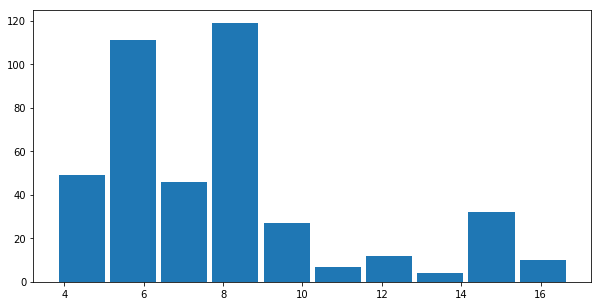

Previsão de Risco:


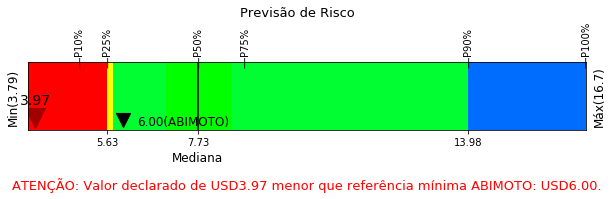




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: ENGRENAGEM DE TRANSMISSAO EM AÇO, SENDO: KIT COROA, PINHAO E CORRENTE PARA MOTOCICLETAS MODELO - REF: KR-BROZ NXR150 - 50TX17TX428HX130L
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 160 BROZ
Valor DI:  USD 4.12
Estatísticas:
qtd de registros:    1816.000000
média simples:          5.664408
desvio padrão:          1.760071
valor mínimo:           1.642000
percentil 25%:          4.387500
percentil 50%:          5.349000
percentil 75%:          5.845760
valor máximo:          11.527981

Percentis:
  '10=1.64', '20=4.04', '25=4.39', '30=4.27', '40=4.51', '50=4.79'
  '60=5.35', '70=5.57', '75=5.85', '80=5.70', '90=6.61', '100=8.69'

Histograma:


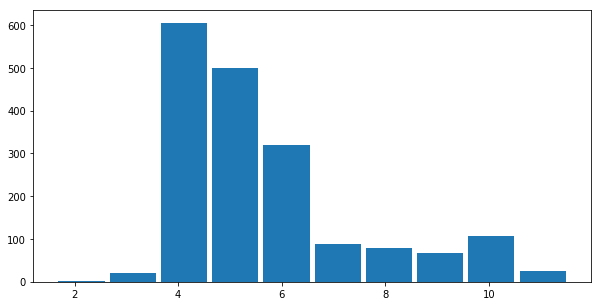

Previsão de Risco:


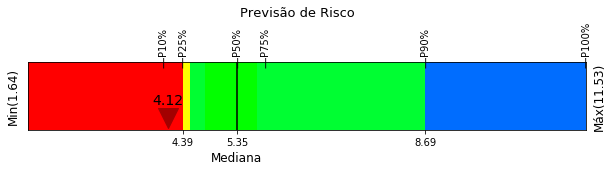




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: Ý10682/T¨ KIT DE TRANSMISSÃO, EM AÇO 1045 TEMPERADO, PARA USO EM MOTOCICLETA, COMPOSTO POR CORRENTE, COROA E PINHÃO, APLICAÇÃO TITAN 160, REF.: 10682/T
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 3.70
Tabela de Referência ABIMOTO
Valor:     USD 4.30

Estatísticas:
qtd de registros:    1390.000000
média simples:          4.059603
desvio padrão:          0.586386
valor mínimo:           1.510000
percentil 25%:          3.683207
percentil 50%:          3.900000
percentil 75%:          4.252000
valor máximo:           6.950000

Percentis:
  '10=1.51', '20=3.57', '25=3.68', '30=3.65', '40=3.73', '50=3.82'
  '60=3.90', '70=4.06', '75=4.25', '80=4.17', '90=4.35', '100=4.70'

Histograma:


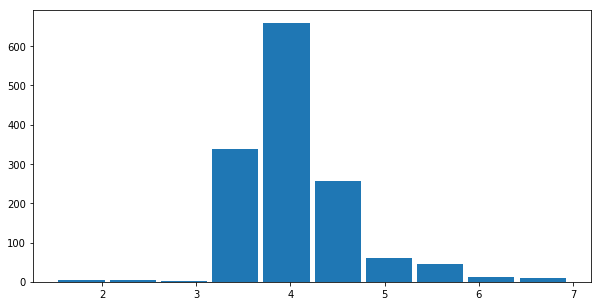

Previsão de Risco:


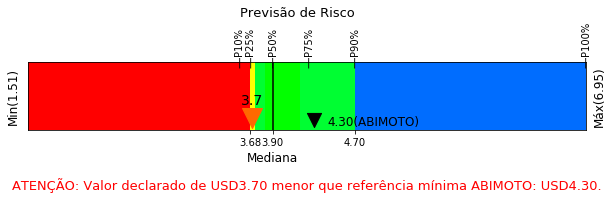




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 980724 KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE, COROA E PINHÃO PARA MOTOCICLETA SUNDOWN HUNTER / MAX 125 428H X 118 X 39T X 15T, MARCA VELTH.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação:  SUNDOWN HUNTER
Valor DI:  USD 3.27
Estatísticas:
qtd de registros:    52.000000
média simples:        3.663424
desvio padrão:        0.476965
valor mínimo:         3.110000
percentil 25%:        3.263818
percentil 50%:        3.629247
percentil 75%:        3.863000
valor máximo:         4.947000

Percentis:
  '10=3.11', '20=3.19', '25=3.26', '30=3.25', '40=3.27', '50=3.34'
  '60=3.63', '70=3.84', '75=3.86', '80=3.86', '90=3.87', '100=4.15'

Histograma:


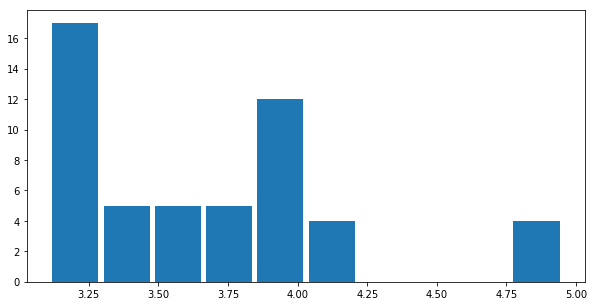

Previsão de Risco:


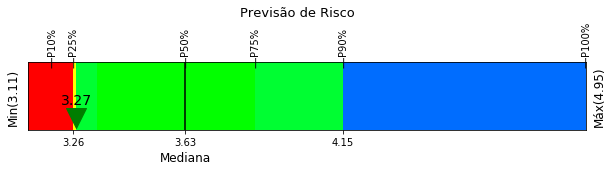




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: "ENGRENAGENS PARA TRANSMISSÃO DE MOTOCICLETAS E CICLOMOTORES SENDO, KIT DE TRANSMISSÃO TITANIUM (1045 ) PARA YBR 125 ( 03-08 ) / YBR 125 FACTOR ( 03-16 ), COMPOSTO DE CORRENTE 428H X 118L, COROA 45Z, PINHÃO 14Z - ITEM 71815.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 3.98
Tabela de Referência ABIMOTO
Valor:     USD 4.20

Estatísticas:
qtd de registros:    1092.000000
média simples:          4.278391
desvio padrão:          0.824252
valor mínimo:           1.436000
percentil 25%:          3.720000
percentil 50%:          4.060000
percentil 75%:          4.702000
valor máximo:           8.150000

Percentis:
  '10=1.44', '20=3.49', '25=3.72', '30=3.65', '40=3.79', '50=3.98'
  '60=4.06', '70=4.14', '75=4.70', '80=4.53', '90=4.85', '100=5.44'

Histograma:


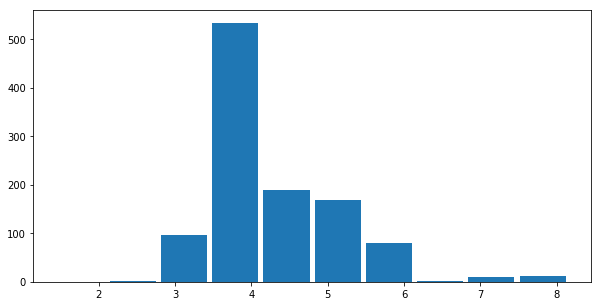

Previsão de Risco:


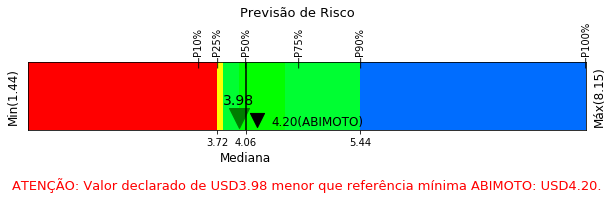




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS WEB100, COMPOSTO DE CORRENTE 428 X SM116 + COROA S40020 36Z + PINHAO 33048 14Z (CERTIFICADO NR. BR31512030) - ITEM: 91238
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: SUNDOWN WEB
Valor DI:  USD 5.29
Estatísticas:
qtd de registros:    257.000000
média simples:         3.857832
desvio padrão:         0.791772
valor mínimo:          2.260000
percentil 25%:         3.283000
percentil 50%:         3.573000
percentil 75%:         4.530000
valor máximo:          5.638000

Percentis:
  '10=2.26', '20=3.00', '25=3.28', '30=3.21', '40=3.35', '50=3.47'
  '60=3.57', '70=3.79', '75=4.53', '80=3.91', '90=4.68', '100=5.29'

Histograma:


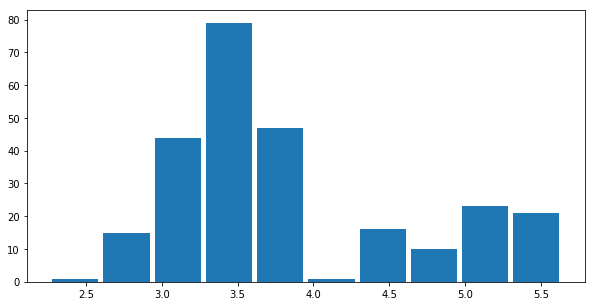

Previsão de Risco:


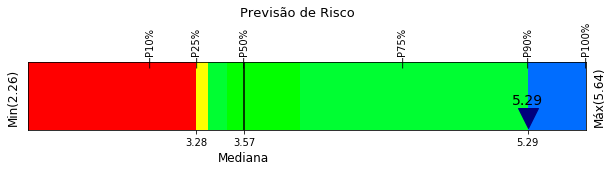




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS FACTOR 150 (16-18), COMPOSTO DE CORRENTE 428 X SM185 + COROA S41705 39Z + PINHAO 26603 14Z - ITEM: 91176
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 5.03
Tabela de Referência ABIMOTO
Valor:     USD 4.20

Estatísticas:
qtd de registros:    1092.000000
média simples:          4.278391
desvio padrão:          0.824252
valor mínimo:           1.436000
percentil 25%:          3.720000
percentil 50%:          4.060000
percentil 75%:          4.702000
valor máximo:           8.150000

Percentis:
  '10=1.44', '20=3.49', '25=3.72', '30=3.65', '40=3.79', '50=3.98'
  '60=4.06', '70=4.14', '75=4.70', '80=4.53', '90=4.85', '100=5.44'

Histograma:


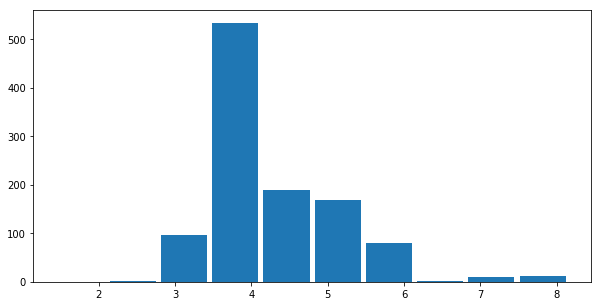

Previsão de Risco:


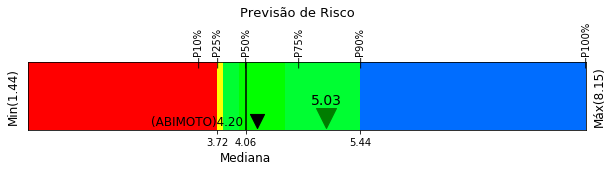




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 22303 - 71817 - KIT DE TRANSMISSAO PARA MOTOCICLETA MODELO XTZ 125 CONTENDO: COROA 48Z - PINHAO 14Z - C/CORRENTE 428H X 122L - TITANIUM (1045)
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA XTZ 125
Valor DI:  USD 5.99
Estatísticas:
qtd de registros:    384.000000
média simples:         5.187649
desvio padrão:         1.553414
valor mínimo:          1.686000
percentil 25%:         3.969500
percentil 50%:         4.505000
percentil 75%:         5.990000
valor máximo:          9.820000

Percentis:
  '10=1.69', '20=3.81', '25=3.97', '30=3.91', '40=4.08', '50=4.35'
  '60=4.50', '70=5.77', '75=5.99', '80=5.95', '90=6.09', '100=6.74'

Histograma:


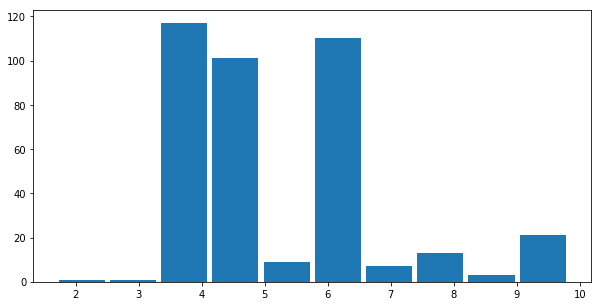

Previsão de Risco:


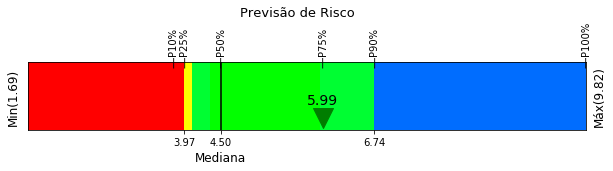




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS C 100 BIZ(13-15), COMPOSTO DE CORRENTE 428 X SM116 + COROA S40173 34Z + PINHAO 25132 14Z (CERTIFICADO NR. BR31512030) - ITEM: 91131
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ C100 125 C125
Valor DI:  USD 3.71
Tabela de Referência ABIMOTO
Valor:     USD 3.90

Estatísticas:
qtd de registros:    1434.000000
média simples:          3.742230
desvio padrão:          0.618322
valor mínimo:           1.202000
percentil 25%:          3.290000
percentil 50%:          3.713600
percentil 75%:          4.090000
valor máximo:           6.511000

Percentis:
  '10=1.20', '20=3.06', '25=3.29', '30=3.23', '40=3.36', '50=3.55'
  '60=3.71', '70=3.79', '75=4.09', '80=3.94', '90=4.13', '100=4.48'

Histograma:


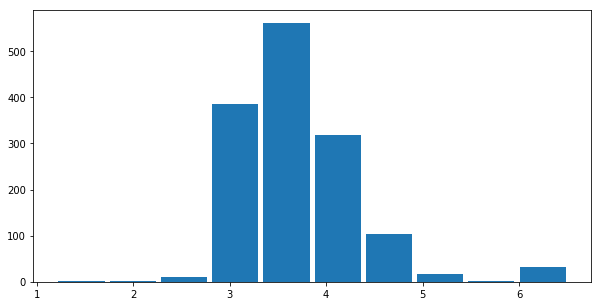

Previsão de Risco:


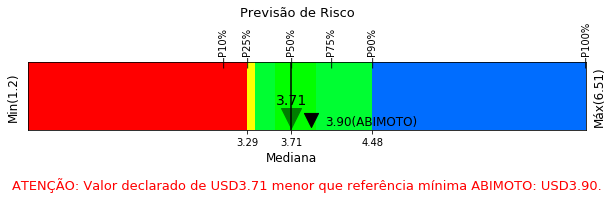




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS CBX 250 TWISTER (01-08), COMPOSTO DE CORRENTE 520 X M136 + COROA 40067 37Z + PINHAO 25138 13Z - ITEM: 71761
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA TWISTER CBX 250
Valor DI:  USD 6.86
Tabela de Referência ABIMOTO
Valor:     USD 6.25

Estatísticas:
qtd de registros:    540.000000
média simples:         7.933863
desvio padrão:         2.866362
valor mínimo:          2.704810
percentil 25%:         5.886239
percentil 50%:         7.402751
percentil 75%:         8.670000
valor máximo:         17.482800

Percentis:
  '10=2.70', '20=5.18', '25=5.89', '30=5.70', '40=6.00', '50=6.86'
  '60=7.40', '70=7.92', '75=8.67', '80=8.47', '90=8.86', '100=12.70'

Histograma:


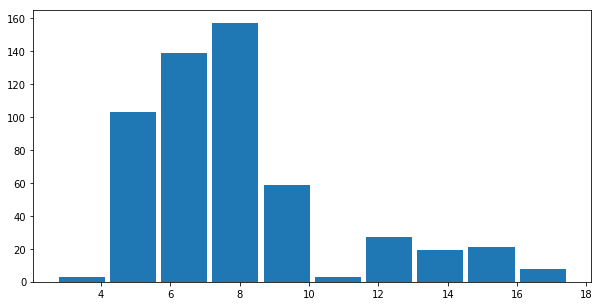

Previsão de Risco:


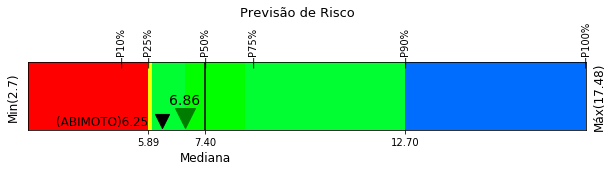




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: item 02;Partes e peças para Motocicletas,Destaque 002-Kit de Transmissão composto de corrente,coroa e pinhão;p/modelo;KIT C 100 BIZ(98-05)/C 100 BIZ +(02-05)35Z X 15Z WITH CHAIN 428H X 108L-TITANIUM(1045);Nas Qdes;100unidades;Ref.;71782.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ C100 125 C125
Valor DI:  USD 4.74
Tabela de Referência ABIMOTO
Valor:     USD 3.90

Estatísticas:
qtd de registros:    1434.000000
média simples:          3.742230
desvio padrão:          0.618322
valor mínimo:           1.202000
percentil 25%:          3.290000
percentil 50%:          3.713600
percentil 75%:          4.090000
valor máximo:           6.511000

Percentis:
  '10=1.20', '20=3.06', '25=3.29', '30=3.23', '40=3.36', '50=3.55'
  '60=3.71', '70=3.79', '75=4.09', '80=3.94', '90=4.13', '100=4.48'

Histograma:


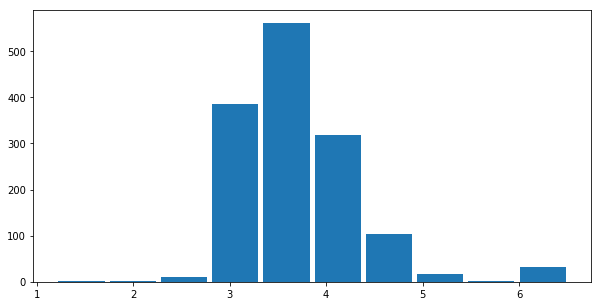

Previsão de Risco:


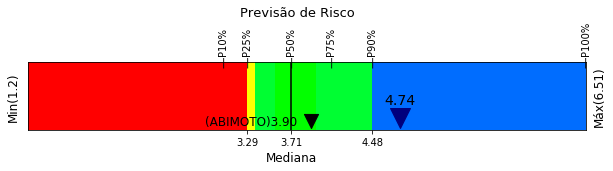




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: ITEM 1000232WR - KIT TRANSMISSÃO COMPOSTO DE COROA, CORRENTE E PINHÃO, PARA MOTOCICLETA MARCA WR COMPATÍVEL BIZ 125 34T-14T/428H 106L EM CX COM 10 UNIDADES
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ C100 125 C125
Valor DI:  USD 30.09
Tabela de Referência ABIMOTO
Valor:     USD 3.90

Estatísticas:
qtd de registros:    1434.000000
média simples:          3.742230
desvio padrão:          0.618322
valor mínimo:           1.202000
percentil 25%:          3.290000
percentil 50%:          3.713600
percentil 75%:          4.090000
valor máximo:           6.511000

Percentis:
  '10=1.20', '20=3.06', '25=3.29', '30=3.23', '40=3.36', '50=3.55'
  '60=3.71', '70=3.79', '75=4.09', '80=3.94', '90=4.13', '100=4.48'

Histograma:


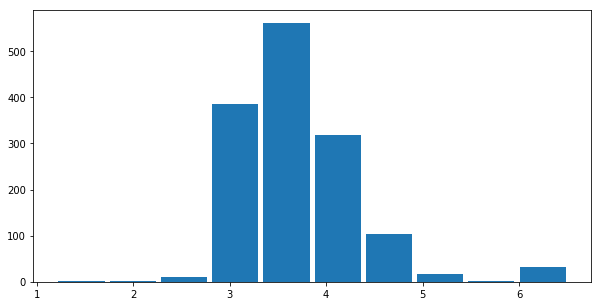

Previsão de Risco:


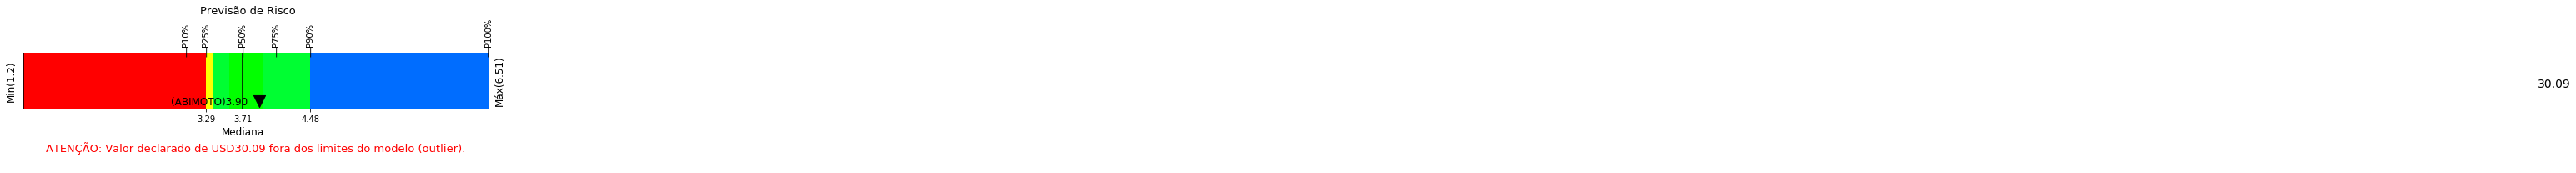




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: COD.: 0366 - KIT DE TRANSMISSAO, MARCA BRANDY, MODELO: HONDA POP 100 - COMPOSTO DE: 01-PC-CORRENTE 428H X 106 (REG.INMETRO: 007096/2019), 01-PC-COROA Z35 (REG.INMETRO: 007093/2019), 01-PC-PINHAO Z14 (REG.INMETRO: 007091/2019) - PARA USO EXCLUSIVO EM
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA POP
Valor DI:  USD 3.31
Estatísticas:
qtd de registros:    717.000000
média simples:         3.708231
desvio padrão:         0.534720
valor mínimo:          1.224000
percentil 25%:         3.280000
percentil 50%:         3.663000
percentil 75%:         4.130000
valor máximo:          5.000000

Percentis:
  '10=1.22', '20=3.04', '25=3.28', '30=3.20', '40=3.33', '50=3.48'
  '60=3.66', '70=3.88', '75=4.13', '80=4.09', '90=4.19', '100=4.48'

Histograma:


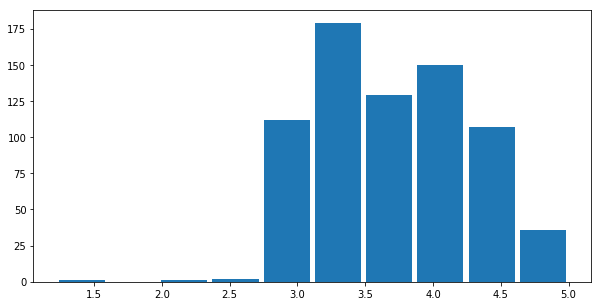

Previsão de Risco:


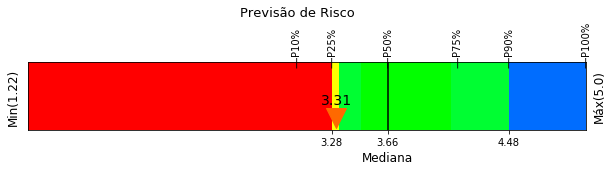




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO P/ MOTOCICLETA MOD: T 115 CRYPTON (10-16) CONTENDO COROA 41Z;PINHAO 15Z;CORRENTE DE TRANSMISSAO 420H X 108L - TITANIUM (1045) 91052 91052
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA CRYPTON
Valor DI:  USD 5.37
Estatísticas:
qtd de registros:    247.000000
média simples:         4.076849
desvio padrão:         0.936688
valor mínimo:          2.840000
percentil 25%:         3.344000
percentil 50%:         3.571000
percentil 75%:         5.191200
valor máximo:          5.777000

Percentis:
  '10=2.84', '20=3.14', '25=3.34', '30=3.23', '40=3.36', '50=3.48'
  '60=3.57', '70=3.75', '75=5.19', '80=5.19', '90=5.24', '100=5.36'

Histograma:


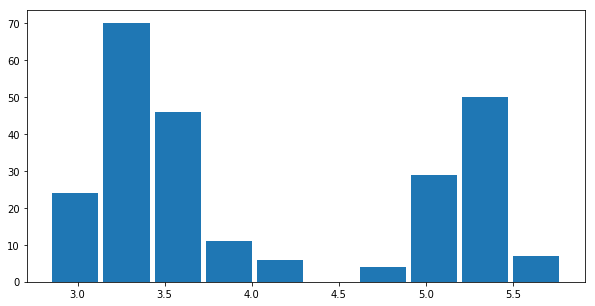

Previsão de Risco:


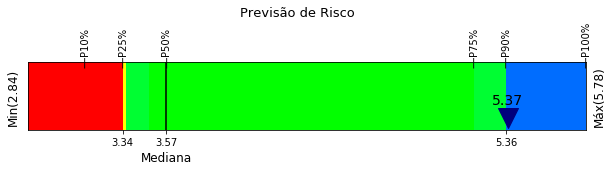




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 880418 - KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE, COROA E PINHÃO, UTILIZADO NAS MOTOS FAN125-16 1045 - MARCA KMC GOLD
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG FAN
Valor DI:  USD 5.41
Estatísticas:
qtd de registros:    2378.000000
média simples:          4.188226
desvio padrão:          0.455430
valor mínimo:           1.554000
percentil 25%:          3.920000
percentil 50%:          4.090000
percentil 75%:          4.528700
valor máximo:           6.870000

Percentis:
  '10=1.55', '20=3.66', '25=3.92', '30=3.87', '40=3.95', '50=4.01'
  '60=4.09', '70=4.18', '75=4.53', '80=4.50', '90=4.58', '100=4.70'

Histograma:


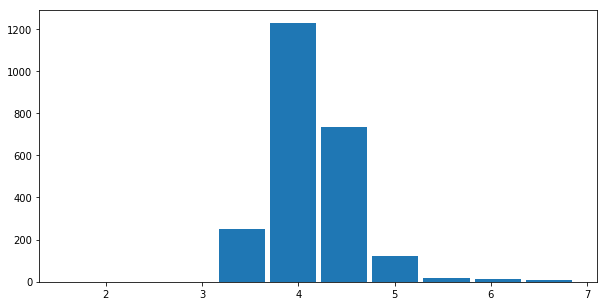

Previsão de Risco:


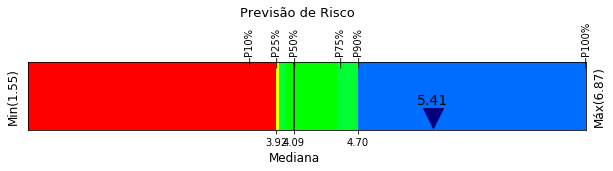




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS WEB 100, COMPOSTO DE CORRENTE 428 X SM116 + COROA S40020 36Z + PINHAO 33048 14Z - ITEM: 91238
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: SUNDOWN WEB
Valor DI:  USD 3.91
Estatísticas:
qtd de registros:    257.000000
média simples:         3.857832
desvio padrão:         0.791772
valor mínimo:          2.260000
percentil 25%:         3.283000
percentil 50%:         3.573000
percentil 75%:         4.530000
valor máximo:          5.638000

Percentis:
  '10=2.26', '20=3.00', '25=3.28', '30=3.21', '40=3.35', '50=3.47'
  '60=3.57', '70=3.79', '75=4.53', '80=3.91', '90=4.68', '100=5.29'

Histograma:


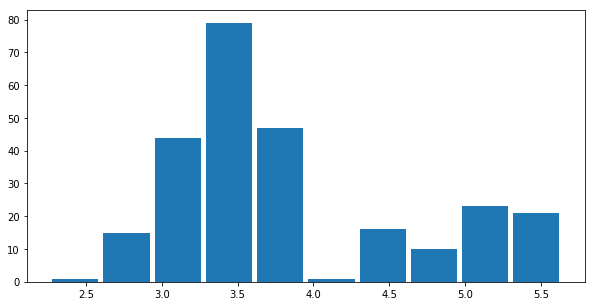

Previsão de Risco:


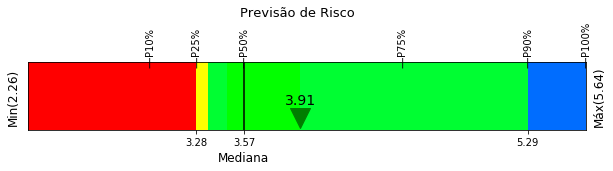




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: FAN 2009 - KIT TRANSMISSAO PARA MOTOCICLETA, COMPOSTO POR CORRENTE, COROA E PINHAO, PARA MOTOCICLETA. DESTAQUE 002 KIT TRANSMISSAO PARA MOTOCICLETA, COMPOSTO POR CORRENTE, COROA E PINHAO.
Origem:    PARAGUAI
Retentor:  sem retentor
Aplicação: HONDA CG FAN
Valor DI:  USD 2.43
Estatísticas:
qtd de registros:    2378.000000
média simples:          4.188226
desvio padrão:          0.455430
valor mínimo:           1.554000
percentil 25%:          3.920000
percentil 50%:          4.090000
percentil 75%:          4.528700
valor máximo:           6.870000

Percentis:
  '10=1.55', '20=3.66', '25=3.92', '30=3.87', '40=3.95', '50=4.01'
  '60=4.09', '70=4.18', '75=4.53', '80=4.50', '90=4.58', '100=4.70'

Histograma:


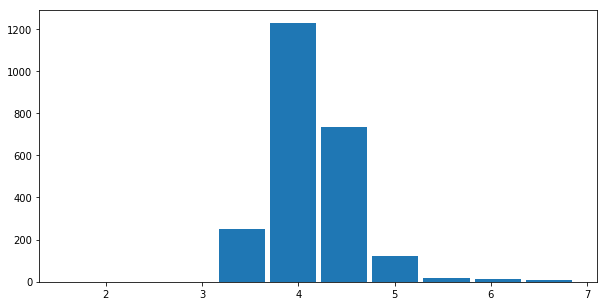

Previsão de Risco:


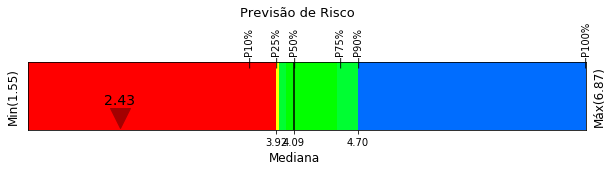




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 007265 # KIT TRANSMISSAO STANDARD TEMP. COMPL. P/ MOTO HONDA BIZ 125 06/10 (34T+14T-428H+106L) COMPOSTO POR CORRENTE, COROA E PINHAO MODELO: STD BIZ 125
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ C100 125 C125
Valor DI:  USD 2.99
Tabela de Referência ABIMOTO
Valor:     USD 3.90

Estatísticas:
qtd de registros:    1434.000000
média simples:          3.742230
desvio padrão:          0.618322
valor mínimo:           1.202000
percentil 25%:          3.290000
percentil 50%:          3.713600
percentil 75%:          4.090000
valor máximo:           6.511000

Percentis:
  '10=1.20', '20=3.06', '25=3.29', '30=3.23', '40=3.36', '50=3.55'
  '60=3.71', '70=3.79', '75=4.09', '80=3.94', '90=4.13', '100=4.48'

Histograma:


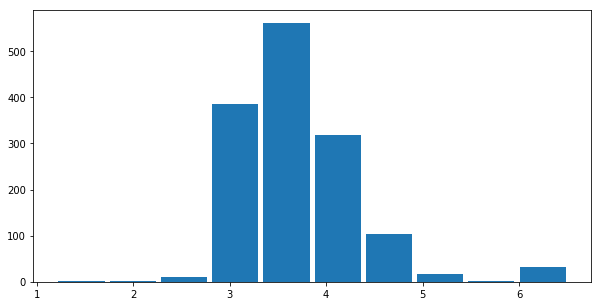

Previsão de Risco:


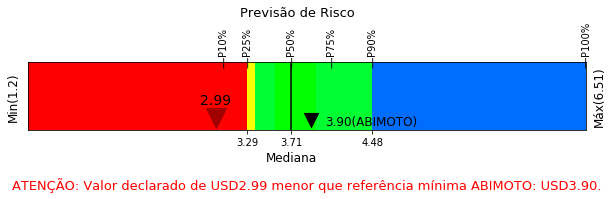




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT HARDT BIZ 125 HO 34*14 - KIT DE TRANSMISSAO COM RETENTOR COMPOSTO DE COROA/PINHAO E CORRENTE PARA MODELO: BIZ 125, COROA/PINHAO: 34*14, CORRENTE DA MOTOCICLETA 428HO E ELOS 106. REF. 55529C.
Origem:    CHINA, REPUBLICA POP
Retentor:  com retentor
Aplicação: HONDA BIZ C100 125 C125
Valor DI:  USD 2.71
Tabela de Referência ABIMOTO
Valor:     USD 6.47

Estatísticas:
qtd de registros:    49.000000
média simples:        5.150480
desvio padrão:        2.354259
valor mínimo:         1.607919
percentil 25%:        3.044100
percentil 50%:        5.363540
percentil 75%:        7.452090
valor máximo:         8.880263

Percentis:
  '10=1.61', '20=2.71', '25=3.04', '30=3.00', '40=3.06', '50=3.26'
  '60=5.36', '70=5.58', '75=7.45', '80=7.07', '90=8.20', '100=8.50'

Histograma:


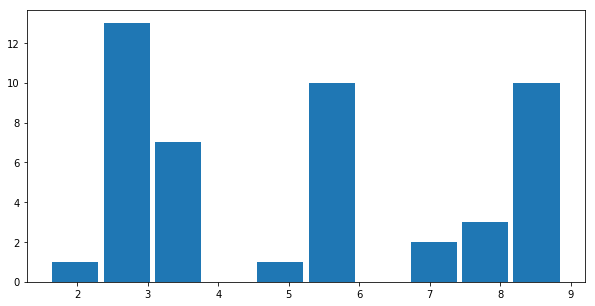

Previsão de Risco:


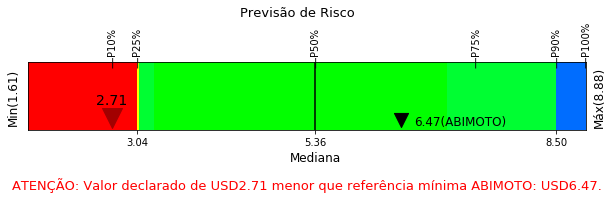




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS CG 125 CARGO (09-13)/ CG 125 FAN (09-13), COMPOSTO DE CORRENTE 428 X SM117 + COROA S40230 43Z + PINHAO 25104 14Z - ITEM: 91048
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG FAN
Valor DI:  USD 4.53
Estatísticas:
qtd de registros:    2378.000000
média simples:          4.188226
desvio padrão:          0.455430
valor mínimo:           1.554000
percentil 25%:          3.920000
percentil 50%:          4.090000
percentil 75%:          4.528700
valor máximo:           6.870000

Percentis:
  '10=1.55', '20=3.66', '25=3.92', '30=3.87', '40=3.95', '50=4.01'
  '60=4.09', '70=4.18', '75=4.53', '80=4.50', '90=4.58', '100=4.70'

Histograma:


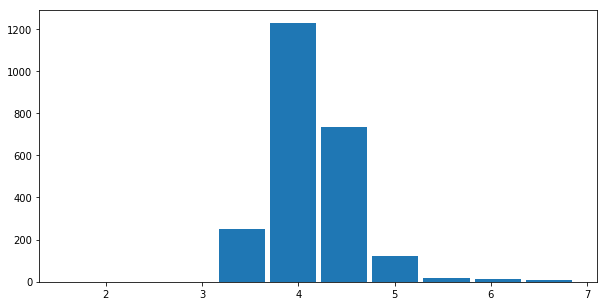

Previsão de Risco:


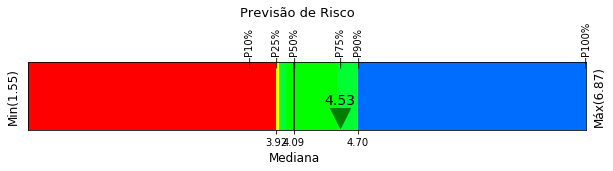




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS CG 125 CARGO (00-04)/ CG 125 FAN (05-08) / CG 125 TITAN (00-04), COMPOSTO DE CORRENTE 428 X SM117 + COROA 40038 44Z + PINHAO 25002 14Z (CERTIFICADO NR. BR31512048) - ITEM: 71790
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG FAN
Valor DI:  USD 4.09
Estatísticas:
qtd de registros:    2378.000000
média simples:          4.188226
desvio padrão:          0.455430
valor mínimo:           1.554000
percentil 25%:          3.920000
percentil 50%:          4.090000
percentil 75%:          4.528700
valor máximo:           6.870000

Percentis:
  '10=1.55', '20=3.66', '25=3.92', '30=3.87', '40=3.95', '50=4.01'
  '60=4.09', '70=4.18', '75=4.53', '80=4.50', '90=4.58', '100=4.70'

Histograma:


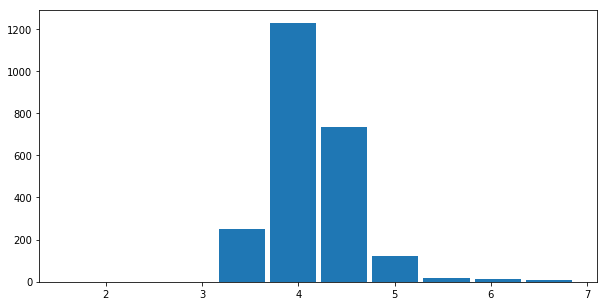

Previsão de Risco:


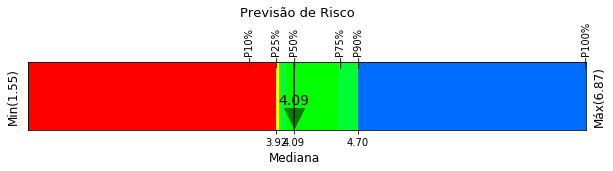




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS NXR 150 BROS (06-15), COMPOSTO DE CORRENTE 428 X M121 + COROA 40176 49Z + PINHAO 25115 17Z (CERTIFICADO NR. BR31512030) - ITEM: 71884
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 160 BROZ
Valor DI:  USD 5.67
Estatísticas:
qtd de registros:    1816.000000
média simples:          5.664408
desvio padrão:          1.760071
valor mínimo:           1.642000
percentil 25%:          4.387500
percentil 50%:          5.349000
percentil 75%:          5.845760
valor máximo:          11.527981

Percentis:
  '10=1.64', '20=4.04', '25=4.39', '30=4.27', '40=4.51', '50=4.79'
  '60=5.35', '70=5.57', '75=5.85', '80=5.70', '90=6.61', '100=8.69'

Histograma:


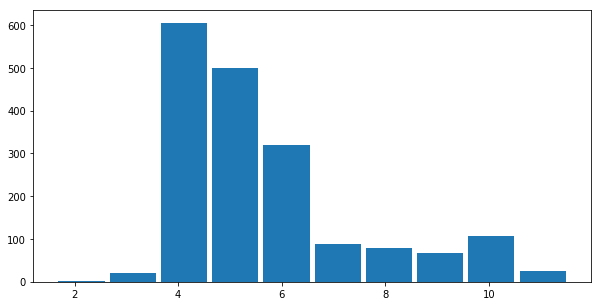

Previsão de Risco:


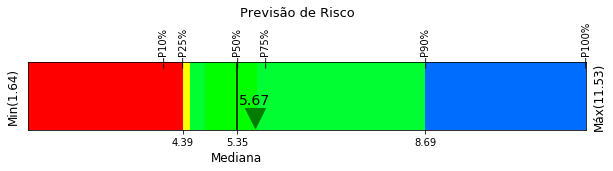




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 10530025 IN KIT TRANSMISSAO P/MOTOCICLETAS(COROA, CORRENTE, PINHAO) MODELO: XTZ-250 LANDER 15D/46D 428HX130L MARCA: SCUD
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA LANDER XTZ 250
Valor DI:  USD 4.37
Tabela de Referência ABIMOTO
Valor:     USD 4.40

Estatísticas:
qtd de registros:    404.000000
média simples:         7.897020
desvio padrão:         3.285275
valor mínimo:          3.782500
percentil 25%:         5.138275
percentil 50%:         7.236458
percentil 75%:        10.172656
valor máximo:         17.473750

Percentis:
  '10=3.78', '20=4.34', '25=5.14', '30=4.46', '40=5.70', '50=6.72'
  '60=7.24', '70=8.30', '75=10.17', '80=8.92', '90=10.46', '100=12.71'

Histograma:


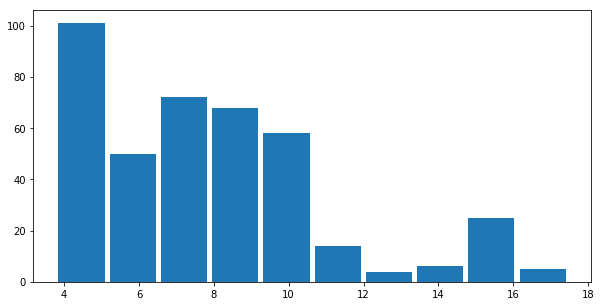

Previsão de Risco:


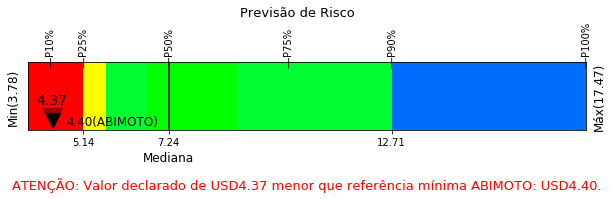




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT TRANSMISSÃO, COMPOSTO DE CORRENTE, COROA E PINHÃO, MODELO: KIT POP 110 34X14 428H X 104L.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA POP
Valor DI:  USD 3.80
Estatísticas:
qtd de registros:    717.000000
média simples:         3.708231
desvio padrão:         0.534720
valor mínimo:          1.224000
percentil 25%:         3.280000
percentil 50%:         3.663000
percentil 75%:         4.130000
valor máximo:          5.000000

Percentis:
  '10=1.22', '20=3.04', '25=3.28', '30=3.20', '40=3.33', '50=3.48'
  '60=3.66', '70=3.88', '75=4.13', '80=4.09', '90=4.19', '100=4.48'

Histograma:


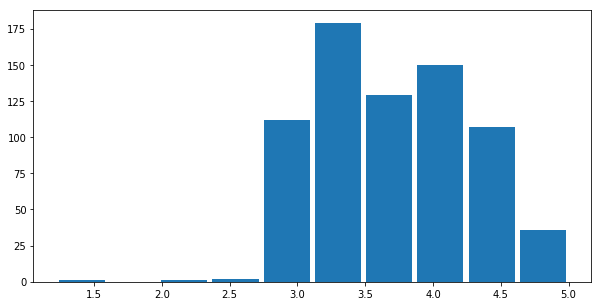

Previsão de Risco:


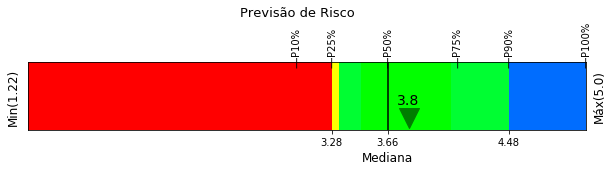




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: REF. KITTR-111 - KIT DE TRANSMISSÃO PARA MOTOCICLETAS, COMPOSTO DE CORRENTE, COROA E PINHÃO, SEM RETENTOR, MODELO: 428Hx128L,48T/16T NXR 160 BROS/XRE 190, MARCA KING.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 160 BROZ
Valor DI:  USD 4.39
Estatísticas:
qtd de registros:    1816.000000
média simples:          5.664408
desvio padrão:          1.760071
valor mínimo:           1.642000
percentil 25%:          4.387500
percentil 50%:          5.349000
percentil 75%:          5.845760
valor máximo:          11.527981

Percentis:
  '10=1.64', '20=4.04', '25=4.39', '30=4.27', '40=4.51', '50=4.79'
  '60=5.35', '70=5.57', '75=5.85', '80=5.70', '90=6.61', '100=8.69'

Histograma:


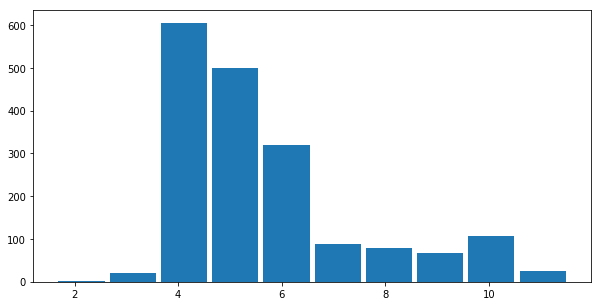

Previsão de Risco:


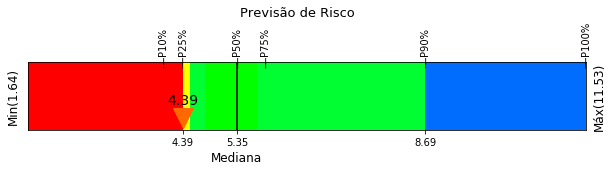




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS CG 125 CARGO (09-13)/ CG 125 FAN (09-13), COMPOSTO DE CORRENTE 428 X SM117 + COROA S40230 43Z + PINHAO 25104 14Z (CERTIFICADO NR. BR31512030) - ITEM: 91048
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG FAN
Valor DI:  USD 3.97
Estatísticas:
qtd de registros:    2378.000000
média simples:          4.188226
desvio padrão:          0.455430
valor mínimo:           1.554000
percentil 25%:          3.920000
percentil 50%:          4.090000
percentil 75%:          4.528700
valor máximo:           6.870000

Percentis:
  '10=1.55', '20=3.66', '25=3.92', '30=3.87', '40=3.95', '50=4.01'
  '60=4.09', '70=4.18', '75=4.53', '80=4.50', '90=4.58', '100=4.70'

Histograma:


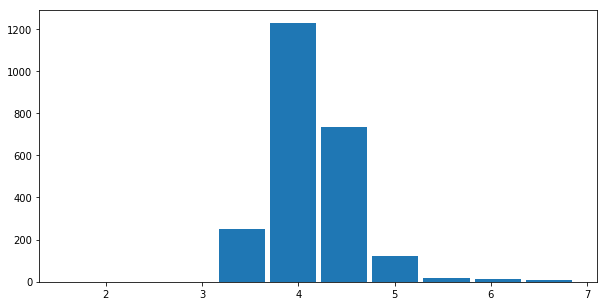

Previsão de Risco:


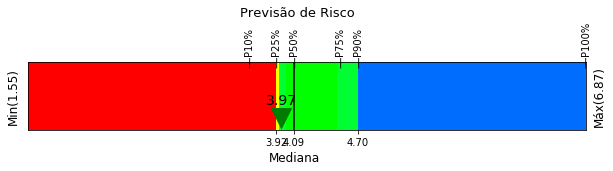




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 007296# KIT TRANSMISSÃO STANDARD TEMPERADO COMPLETO COMPOSTO COM CORRENTE, COROA E PINHAO P/ MOTO HONDA CG 125 FAN 09/13. (43T+14T-428H+116L) MODELO: STD FAN 09
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG FAN
Valor DI:  USD 3.69
Estatísticas:
qtd de registros:    2378.000000
média simples:          4.188226
desvio padrão:          0.455430
valor mínimo:           1.554000
percentil 25%:          3.920000
percentil 50%:          4.090000
percentil 75%:          4.528700
valor máximo:           6.870000

Percentis:
  '10=1.55', '20=3.66', '25=3.92', '30=3.87', '40=3.95', '50=4.01'
  '60=4.09', '70=4.18', '75=4.53', '80=4.50', '90=4.58', '100=4.70'

Histograma:


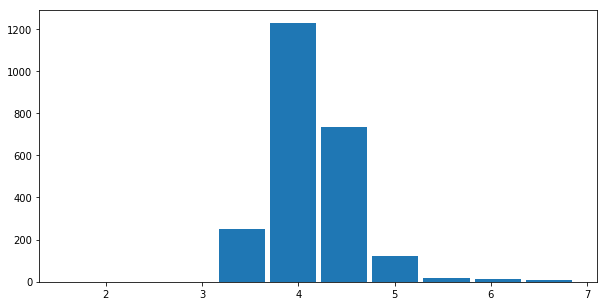

Previsão de Risco:


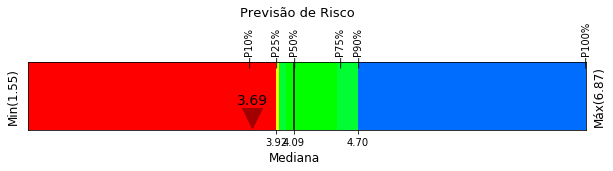




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 20246/i45 - KIT DE TRANSMISSÃO EM AÇO 1045, COMPOSTO POR CORRENTE, COROA E PINHÃO, APLICAÇÃO YS 150 FAZER (41T/14T/428H x 126L) Standartt
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FAZER YS150 150
Valor DI:  USD 3.84
Estatísticas:
qtd de registros:    436.000000
média simples:         4.848136
desvio padrão:         1.226630
valor mínimo:          2.956300
percentil 25%:         3.825000
percentil 50%:         4.800000
percentil 75%:         5.654850
valor máximo:          9.790000

Percentis:
  '10=2.96', '20=3.55', '25=3.83', '30=3.75', '40=3.87', '50=4.28'
  '60=4.80', '70=5.23', '75=5.65', '80=5.65', '90=5.72', '100=5.83'

Histograma:


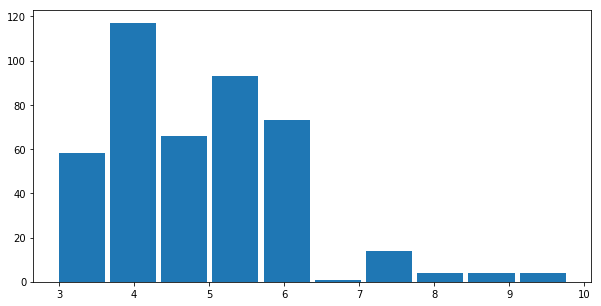

Previsão de Risco:


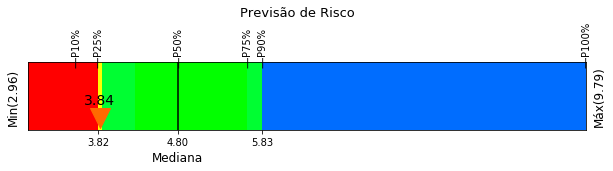




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 10405/i45 DESTAQUE NCM 002 KIT DE TRANSMISSAO COMPOSTO DE COROA, CORRENTE E PINHAO KIT DE TRANSMISSÃO, EM AÇO 1045, PARA USO EM MOTOCICLETA COMPOSTO POR CORRENTE, COROA E PINHÃO, APLICAÇÃO XLR 125 (50T/15T/428H x 126L) MARCA SIVERST
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA XLR
Valor DI:  USD 4.95
Estatísticas:
qtd de registros:    207.000000
média simples:         5.367161
desvio padrão:         1.222917
valor mínimo:          3.880000
percentil 25%:         4.445000
percentil 50%:         4.750000
percentil 75%:         6.500000
valor máximo:          8.399000

Percentis:
  '10=3.88', '20=4.26', '25=4.45', '30=4.36', '40=4.60', '50=4.68'
  '60=4.75', '70=4.82', '75=6.50', '80=6.39', '90=6.55', '100=7.35'

Histograma:


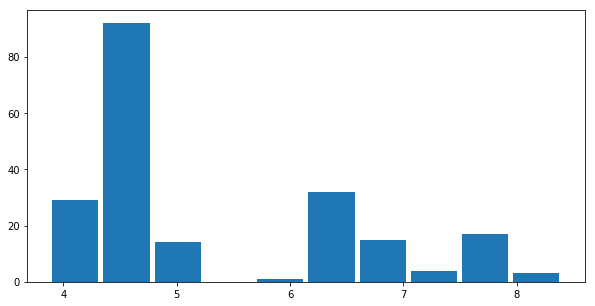

Previsão de Risco:


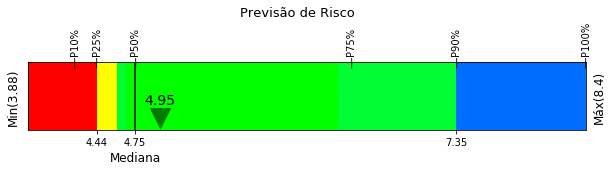




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO COMPOSTO DE CORRENTE, COROA (EM AÇO 1045) E PINHAO (EM AÇO 1045) COMPATIVEL COM MOTOCICLETA(S) MODELO(S): CG TITAN 160 (15-44Dx428Hx118). MARCA: CEVER.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 3.99
Tabela de Referência ABIMOTO
Valor:     USD 4.30

Estatísticas:
qtd de registros:    1390.000000
média simples:          4.059603
desvio padrão:          0.586386
valor mínimo:           1.510000
percentil 25%:          3.683207
percentil 50%:          3.900000
percentil 75%:          4.252000
valor máximo:           6.950000

Percentis:
  '10=1.51', '20=3.57', '25=3.68', '30=3.65', '40=3.73', '50=3.82'
  '60=3.90', '70=4.06', '75=4.25', '80=4.17', '90=4.35', '100=4.70'

Histograma:


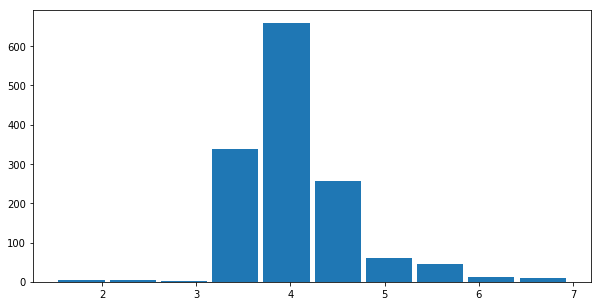

Previsão de Risco:


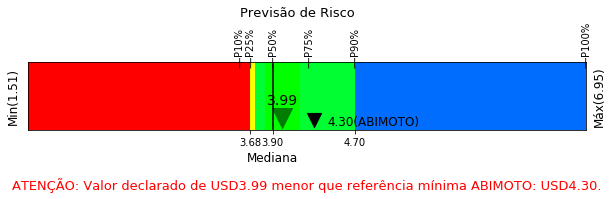




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: ITEM 7906 - KIT TRANSMISSÃO PARA MOTOCICLETA, COMPOSTO DE COROA, CORRENTE E PINHAO PARA MOTOCICLETA MARCA BMK COMPATIVEL YBR 125 03/08/FACTOR 43T-14T/428H 118L AÇO 1045 (20 CAIXAS CONTENDO 10 UNIDADES CADA)
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 3.40
Tabela de Referência ABIMOTO
Valor:     USD 4.20

Estatísticas:
qtd de registros:    1092.000000
média simples:          4.278391
desvio padrão:          0.824252
valor mínimo:           1.436000
percentil 25%:          3.720000
percentil 50%:          4.060000
percentil 75%:          4.702000
valor máximo:           8.150000

Percentis:
  '10=1.44', '20=3.49', '25=3.72', '30=3.65', '40=3.79', '50=3.98'
  '60=4.06', '70=4.14', '75=4.70', '80=4.53', '90=4.85', '100=5.44'

Histograma:


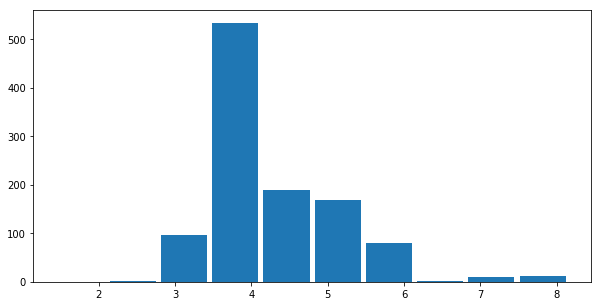

Previsão de Risco:


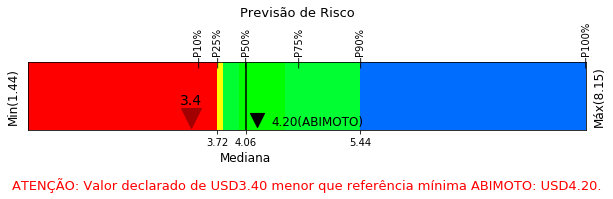




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 5008.809.204 - "KIT TRANSMISSAO UNIFORT (COROA, CORRENTE E PINHAO) CORRENTE 428X116 SEM RETENTOR, COROA 44 DENTES, PINHAO 14 DENTES, MARCA: Unifort. APLICACAO: TITAN 125 KS/ES 95>04"
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 4.05
Tabela de Referência ABIMOTO
Valor:     USD 4.30

Estatísticas:
qtd de registros:    1390.000000
média simples:          4.059603
desvio padrão:          0.586386
valor mínimo:           1.510000
percentil 25%:          3.683207
percentil 50%:          3.900000
percentil 75%:          4.252000
valor máximo:           6.950000

Percentis:
  '10=1.51', '20=3.57', '25=3.68', '30=3.65', '40=3.73', '50=3.82'
  '60=3.90', '70=4.06', '75=4.25', '80=4.17', '90=4.35', '100=4.70'

Histograma:


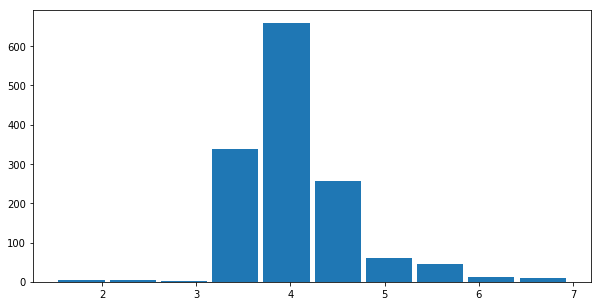

Previsão de Risco:


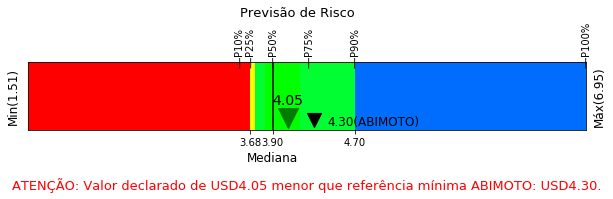




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 20181/i45 - KIT DE TRANSMISSÃO EM AÇO 1045, MARCA SILVERST, COMPOSTO POR CORRENTE, COROA E PINHÃO, PARA MOTOCICLETA YBR125 03/08 (45T/ 14T/428H X 118L).
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 3.56
Tabela de Referência ABIMOTO
Valor:     USD 4.20

Estatísticas:
qtd de registros:    1092.000000
média simples:          4.278391
desvio padrão:          0.824252
valor mínimo:           1.436000
percentil 25%:          3.720000
percentil 50%:          4.060000
percentil 75%:          4.702000
valor máximo:           8.150000

Percentis:
  '10=1.44', '20=3.49', '25=3.72', '30=3.65', '40=3.79', '50=3.98'
  '60=4.06', '70=4.14', '75=4.70', '80=4.53', '90=4.85', '100=5.44'

Histograma:


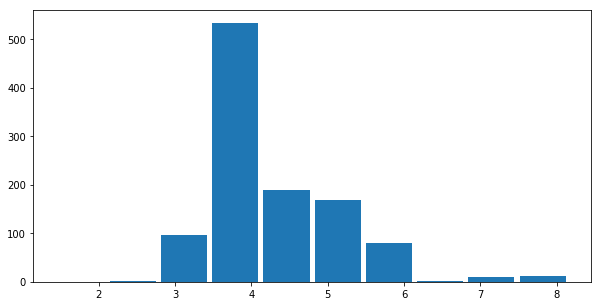

Previsão de Risco:


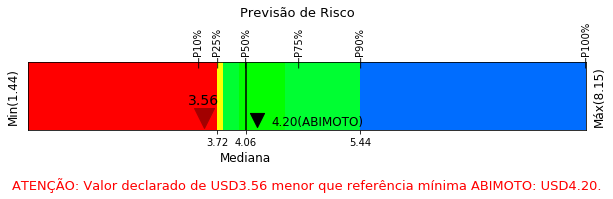

In [14]:
riscoValor(dfimp)

In [15]:
tempotot=time.time()-initot
if tempotot>60:
    print(f'Tempo total de execução: {tempotot/60:.2f} minutos.')
else:
    print(f'Tempo total de execução: {tempotot:.2f} segundos.')

Tempo total de execução: 14.28 segundos.
